In [71]:
import string
import csv
import unicodedata
import random
import torch
import torch.nn as nn
from random import shuffle
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as mp
import math

In [2]:
def getdata():
    category_lines = {}
    all_categories = ['st']
    category_lines['st'] = []
    filterwords = ['NEXTEPISODE']
    
    with open('./startrek/star_trek_transcripts_all_episodes.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            for el in row:
                if (el not in filterwords) and (len(el) > 1):
                    #.replace(’=’,’’) #.replace(’/’,’ ’)
                    v = el.strip().replace(';','').replace('\"','') 
                    v = unicodeToAscii(v)
                    category_lines['st'].append(v)
    n_categories = len(all_categories)
    print(len(all_categories), len(category_lines['st']))
    print('done')
    
    return category_lines, all_categories

In [3]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = all_categories[0]
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return letter_indexes

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [5]:
def train_test_split(adict):
    categories = list(adict.keys())
    train_dict = {}
    test_dict = {}
    for category in categories:
        train_dict[category] = adict[category][:int(len(adict[category])*0.8)]
        test_dict[category] = adict[category][int(len(adict[category])*0.8):]
    return train_dict, test_dict

In [6]:
# Model
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers)
        self.dropout = torch.nn.Dropout(0.1)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax()
        
    def forward(self, x, h0, c0):
#         h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
#         c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        lstm_output, (h_0, c_0) = self.lstm(x, (h0, c0))
        drop_out = self.dropout(lstm_output[-1, :, :])
        output = self.fc(drop_out)
        opt = self.softmax(output/0.5)
        return opt, (h_0, c_0)

In [7]:
class iteratefromdict():
    def __init__(self, adict):
        self.ct = 0
        self.namlab = []
        shuffle(adict['st'])
        for i in range(len(adict['st'])):
#         for i in range(100):
            temp_name = inputTensor(adict['st'][i])
            temp_index = targetTensor(adict['st'][i])
            self.namlab.append((temp_name, temp_index))
        
    def num(self):
        return len(self.namlab)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.ct == len(self.namlab):
            # reset before raising iteration for reusal
            shuffle(self.namlab)
            self.ct = 0
            # raise
            raise StopIteration()
        else:
            self.ct += 1
            # return feature-label pair here
            return self.namlab[self.ct - 1][0], self.namlab[self.ct - 1][1]

In [8]:
def trainRNN(model, optimizer, train_iter):
    criterion = torch.nn.NLLLoss()
#     myiter = iteratefromdict(category_lines, n_categories)
    model.train()
    opt_loss = 0
    num_enu = 0
    for i, (images, labels) in enumerate(train_iter):
        print('--- train ---', i)
        loss = 0
        enu = 0
        optimizer.zero_grad()
        h0 = torch.zeros(2, 1, 100)
        c0 = torch.zeros(2, 1, 100)
        for j in range(images.size(0)):
            temp = torch.unsqueeze(images[j], 0)
            output, (h0, c0) = model(temp, h0, c0)
#             print(output.argmax(dim=1))
#             print(output.size())
            label = torch.tensor([labels[j]])
            l = criterion(output, label)
#             l.backward()
            loss += l
            enu +=1
        loss.backward()
        optimizer.step()
        avg_loss = loss.item() / enu
        num_enu += 1
        opt_loss += avg_loss
    opt_loss /= num_enu
    print('Train set: Average loss:', opt_loss)
    return opt_loss

In [9]:
def testRNN(model, optimizer, test_iter):
    criterion = torch.nn.NLLLoss()
    model.eval()
    val_loss = 0
    num_enu = 0
    num_char = 0
    correct = 0
    cen_list = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_iter):
            print('--- test ---', i)
            loss = 0
            enu = 0
            h0 = torch.zeros(2, 1, 100)
            c0 = torch.zeros(2, 1, 100)
            centence = ''
            true_cen = ''
            for j in range(images.size(0)):
                temp = torch.unsqueeze(images[j], 0)
                output, (h0, c0) = model(temp,h0, c0)
                label = torch.tensor([labels[j]])
                l = criterion(output, label)
                loss += l
                enu += 1
                num_char += 1
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()
                if pred.item() == 77:
                    centence += '<EOS>'
                else:
                    centence += all_letters[pred.item()]
                if label.item() == 77:
                    true_cen += '<EOS>'
                else:
                    true_cen += all_letters[label.item()]
            avg_loss = loss.item() / enu
            num_enu += 1
            val_loss += avg_loss
            cen_list.append((true_cen, centence))
        val_loss /= num_enu
        final_acc = float(correct) / num_char
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({}%)'.format(
        val_loss, correct, num_char,
        100. * final_acc))
        return final_acc, val_loss, cen_list

In [131]:
def nn(model, num_epoch, train_iter, test_iter):
    optimizer = optim.SGD(model.parameters(), lr=0.02)
    best_acc = -1
    best_model = None
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    centences_list = []
    samples = []
    for epoch in range(num_epoch):
        print('Epoch', epoch + 1, '/', num_epoch, ':')
        train_loss = trainRNN(model, optimizer, train_iter)
        final_acc, val_loss, cen_list = testRNN(model, optimizer, test_iter)
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss_list)
        val_acc_list.append(final_acc)
        centences_list.append(cen_list)
        sample = generate_sample(model)
        samples.append(sample)
        outF = open('sample'+str(epoch)+'.txt', 'w')
        for line in sample:
            outF.write(line)
            outF.write('\n')
        outF.close()
        if final_acc > best_acc:
            best_epoch = epoch + 1
            best_acc = final_acc
            best_model = model.state_dict()
    return train_loss_list, val_loss_list, val_acc_list, best_epoch, centences_list, best_model, samples
    

In [119]:
def generate_sample(model):
    start_letters = "ABCDEFGHIJKLMNOPRSTUVWZ"
    all_letters = string.ascii_letters + "0123456789 .,:!?’[]()/+-="
    samples = []
    for i in range(20):
        counter = 0
        sample_string = ''
        h0 = torch.zeros(2, 1, 100)
        c0 = torch.zeros(2, 1, 100)
        
        starter = start_letters[random.randint(0, len(start_letters)-1)]
        sample_string += starter
#         print(sample_string)
        next_char, (h0, c0) = model(inputTensor(starter), h0, c0)
        next_char_list = next_char.detach().numpy().tolist()[0]
        for j in range(len(next_char_list)):
            next_char_list[j] = math.exp(next_char_list[j])
        next_char_lists = []
        for j in range(len(next_char_list)):
            next_char_lists.append(next_char_list[j]/sum(next_char_list))
        next_char_index = np.random.choice(78, 1, p=next_char_lists)[0]
        
        while(next_char_index != len(all_letters) and counter < 30):  
            next_char = torch.unsqueeze(next_char, 0)
            next_char, (h0, c0) = model(next_char, h0, c0)
            next_char_list = next_char.detach().numpy().tolist()[0]
            for j in range(len(next_char_list)):
                next_char_list[j] = math.exp(next_char_list[j])
            next_char_lists = []
            for j in range(len(next_char_list)):
                next_char_lists.append(next_char_list[j]/sum(next_char_list))
            next_char_index = np.random.choice(78,1,p=next_char_lists)[0]
            if next_char_index == len(all_letters):
                sample_string += '<EOS>'
            else:
                sample_string += all_letters[next_char_index]
#             print(sample_string)
            counter += 1
#             print(counter)
        samples.append(sample_string)
        print(sample_string)
    return samples

In [18]:
def plot_graph(train_lost_list, val_loss_list, val_acc_list, best_epoch, flag):
    fig1, ax1 = plt.subplots()
    ax1.plot(np.arange(len(train_lost_list)), train_lost_list)
    ax1.plot(np.arange(len(val_loss_list)), val_loss_list)
    ax1.set_title('Train and Test Loss for Network ' + flag)
    ax1.legend(['training loss', 'testing loss'], loc='upper right')
    mp.savefig('figures/nn'+flag+'_fig1.png')
    plt.show()
    
    fig2, ax2 = plt.subplots()
    ax2.plot(np.arange(len(val_acc_list)), val_acc_list)
    ax2.set_title('Test accuracy for Network ' + flag)
    ax2.legend(['validation accuracy'], loc='lower right')
    mp.savefig('figures/nn'+flag+'_fig2.png')
    plt.show()
    
    print('The best epoch is', best_epoch)

1 36339
done
Epoch 1 / 1 :
--- train --- 0
--- train --- 1
--- train --- 2
--- train --- 3
--- train --- 4
--- train --- 5


/Users/lixingxuan/anaconda3/envs/tesnorflow/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


--- train --- 6
--- train --- 7
--- train --- 8
--- train --- 9
--- train --- 10
--- train --- 11
--- train --- 12
--- train --- 13
--- train --- 14
--- train --- 15
--- train --- 16
--- train --- 17
--- train --- 18
--- train --- 19
--- train --- 20
--- train --- 21
--- train --- 22
--- train --- 23
--- train --- 24
--- train --- 25
--- train --- 26
--- train --- 27
--- train --- 28
--- train --- 29
--- train --- 30
--- train --- 31
--- train --- 32
--- train --- 33
--- train --- 34
--- train --- 35
--- train --- 36
--- train --- 37
--- train --- 38
--- train --- 39
--- train --- 40
--- train --- 41
--- train --- 42
--- train --- 43
--- train --- 44
--- train --- 45
--- train --- 46
--- train --- 47
--- train --- 48
--- train --- 49
--- train --- 50
--- train --- 51
--- train --- 52
--- train --- 53
--- train --- 54
--- train --- 55
--- train --- 56
--- train --- 57
--- train --- 58
--- train --- 59
--- train --- 60
--- train --- 61
--- train --- 62
--- train --- 63
--- train --- 64
-

--- train --- 469
--- train --- 470
--- train --- 471
--- train --- 472
--- train --- 473
--- train --- 474
--- train --- 475
--- train --- 476
--- train --- 477
--- train --- 478
--- train --- 479
--- train --- 480
--- train --- 481
--- train --- 482
--- train --- 483
--- train --- 484
--- train --- 485
--- train --- 486
--- train --- 487
--- train --- 488
--- train --- 489
--- train --- 490
--- train --- 491
--- train --- 492
--- train --- 493
--- train --- 494
--- train --- 495
--- train --- 496
--- train --- 497
--- train --- 498
--- train --- 499
--- train --- 500
--- train --- 501
--- train --- 502
--- train --- 503
--- train --- 504
--- train --- 505
--- train --- 506
--- train --- 507
--- train --- 508
--- train --- 509
--- train --- 510
--- train --- 511
--- train --- 512
--- train --- 513
--- train --- 514
--- train --- 515
--- train --- 516
--- train --- 517
--- train --- 518
--- train --- 519
--- train --- 520
--- train --- 521
--- train --- 522
--- train --- 523
--- train 

--- train --- 925
--- train --- 926
--- train --- 927
--- train --- 928
--- train --- 929
--- train --- 930
--- train --- 931
--- train --- 932
--- train --- 933
--- train --- 934
--- train --- 935
--- train --- 936
--- train --- 937
--- train --- 938
--- train --- 939
--- train --- 940
--- train --- 941
--- train --- 942
--- train --- 943
--- train --- 944
--- train --- 945
--- train --- 946
--- train --- 947
--- train --- 948
--- train --- 949
--- train --- 950
--- train --- 951
--- train --- 952
--- train --- 953
--- train --- 954
--- train --- 955
--- train --- 956
--- train --- 957
--- train --- 958
--- train --- 959
--- train --- 960
--- train --- 961
--- train --- 962
--- train --- 963
--- train --- 964
--- train --- 965
--- train --- 966
--- train --- 967
--- train --- 968
--- train --- 969
--- train --- 970
--- train --- 971
--- train --- 972
--- train --- 973
--- train --- 974
--- train --- 975
--- train --- 976
--- train --- 977
--- train --- 978
--- train --- 979
--- train 

--- train --- 1361
--- train --- 1362
--- train --- 1363
--- train --- 1364
--- train --- 1365
--- train --- 1366
--- train --- 1367
--- train --- 1368
--- train --- 1369
--- train --- 1370
--- train --- 1371
--- train --- 1372
--- train --- 1373
--- train --- 1374
--- train --- 1375
--- train --- 1376
--- train --- 1377
--- train --- 1378
--- train --- 1379
--- train --- 1380
--- train --- 1381
--- train --- 1382
--- train --- 1383
--- train --- 1384
--- train --- 1385
--- train --- 1386
--- train --- 1387
--- train --- 1388
--- train --- 1389
--- train --- 1390
--- train --- 1391
--- train --- 1392
--- train --- 1393
--- train --- 1394
--- train --- 1395
--- train --- 1396
--- train --- 1397
--- train --- 1398
--- train --- 1399
--- train --- 1400
--- train --- 1401
--- train --- 1402
--- train --- 1403
--- train --- 1404
--- train --- 1405
--- train --- 1406
--- train --- 1407
--- train --- 1408
--- train --- 1409
--- train --- 1410
--- train --- 1411
--- train --- 1412
--- train --

--- train --- 1797
--- train --- 1798
--- train --- 1799
--- train --- 1800
--- train --- 1801
--- train --- 1802
--- train --- 1803
--- train --- 1804
--- train --- 1805
--- train --- 1806
--- train --- 1807
--- train --- 1808
--- train --- 1809
--- train --- 1810
--- train --- 1811
--- train --- 1812
--- train --- 1813
--- train --- 1814
--- train --- 1815
--- train --- 1816
--- train --- 1817
--- train --- 1818
--- train --- 1819
--- train --- 1820
--- train --- 1821
--- train --- 1822
--- train --- 1823
--- train --- 1824
--- train --- 1825
--- train --- 1826
--- train --- 1827
--- train --- 1828
--- train --- 1829
--- train --- 1830
--- train --- 1831
--- train --- 1832
--- train --- 1833
--- train --- 1834
--- train --- 1835
--- train --- 1836
--- train --- 1837
--- train --- 1838
--- train --- 1839
--- train --- 1840
--- train --- 1841
--- train --- 1842
--- train --- 1843
--- train --- 1844
--- train --- 1845
--- train --- 1846
--- train --- 1847
--- train --- 1848
--- train --

--- train --- 2229
--- train --- 2230
--- train --- 2231
--- train --- 2232
--- train --- 2233
--- train --- 2234
--- train --- 2235
--- train --- 2236
--- train --- 2237
--- train --- 2238
--- train --- 2239
--- train --- 2240
--- train --- 2241
--- train --- 2242
--- train --- 2243
--- train --- 2244
--- train --- 2245
--- train --- 2246
--- train --- 2247
--- train --- 2248
--- train --- 2249
--- train --- 2250
--- train --- 2251
--- train --- 2252
--- train --- 2253
--- train --- 2254
--- train --- 2255
--- train --- 2256
--- train --- 2257
--- train --- 2258
--- train --- 2259
--- train --- 2260
--- train --- 2261
--- train --- 2262
--- train --- 2263
--- train --- 2264
--- train --- 2265
--- train --- 2266
--- train --- 2267
--- train --- 2268
--- train --- 2269
--- train --- 2270
--- train --- 2271
--- train --- 2272
--- train --- 2273
--- train --- 2274
--- train --- 2275
--- train --- 2276
--- train --- 2277
--- train --- 2278
--- train --- 2279
--- train --- 2280
--- train --

--- train --- 2664
--- train --- 2665
--- train --- 2666
--- train --- 2667
--- train --- 2668
--- train --- 2669
--- train --- 2670
--- train --- 2671
--- train --- 2672
--- train --- 2673
--- train --- 2674
--- train --- 2675
--- train --- 2676
--- train --- 2677
--- train --- 2678
--- train --- 2679
--- train --- 2680
--- train --- 2681
--- train --- 2682
--- train --- 2683
--- train --- 2684
--- train --- 2685
--- train --- 2686
--- train --- 2687
--- train --- 2688
--- train --- 2689
--- train --- 2690
--- train --- 2691
--- train --- 2692
--- train --- 2693
--- train --- 2694
--- train --- 2695
--- train --- 2696
--- train --- 2697
--- train --- 2698
--- train --- 2699
--- train --- 2700
--- train --- 2701
--- train --- 2702
--- train --- 2703
--- train --- 2704
--- train --- 2705
--- train --- 2706
--- train --- 2707
--- train --- 2708
--- train --- 2709
--- train --- 2710
--- train --- 2711
--- train --- 2712
--- train --- 2713
--- train --- 2714
--- train --- 2715
--- train --

--- train --- 3097
--- train --- 3098
--- train --- 3099
--- train --- 3100
--- train --- 3101
--- train --- 3102
--- train --- 3103
--- train --- 3104
--- train --- 3105
--- train --- 3106
--- train --- 3107
--- train --- 3108
--- train --- 3109
--- train --- 3110
--- train --- 3111
--- train --- 3112
--- train --- 3113
--- train --- 3114
--- train --- 3115
--- train --- 3116
--- train --- 3117
--- train --- 3118
--- train --- 3119
--- train --- 3120
--- train --- 3121
--- train --- 3122
--- train --- 3123
--- train --- 3124
--- train --- 3125
--- train --- 3126
--- train --- 3127
--- train --- 3128
--- train --- 3129
--- train --- 3130
--- train --- 3131
--- train --- 3132
--- train --- 3133
--- train --- 3134
--- train --- 3135
--- train --- 3136
--- train --- 3137
--- train --- 3138
--- train --- 3139
--- train --- 3140
--- train --- 3141
--- train --- 3142
--- train --- 3143
--- train --- 3144
--- train --- 3145
--- train --- 3146
--- train --- 3147
--- train --- 3148
--- train --

--- train --- 3529
--- train --- 3530
--- train --- 3531
--- train --- 3532
--- train --- 3533
--- train --- 3534
--- train --- 3535
--- train --- 3536
--- train --- 3537
--- train --- 3538
--- train --- 3539
--- train --- 3540
--- train --- 3541
--- train --- 3542
--- train --- 3543
--- train --- 3544
--- train --- 3545
--- train --- 3546
--- train --- 3547
--- train --- 3548
--- train --- 3549
--- train --- 3550
--- train --- 3551
--- train --- 3552
--- train --- 3553
--- train --- 3554
--- train --- 3555
--- train --- 3556
--- train --- 3557
--- train --- 3558
--- train --- 3559
--- train --- 3560
--- train --- 3561
--- train --- 3562
--- train --- 3563
--- train --- 3564
--- train --- 3565
--- train --- 3566
--- train --- 3567
--- train --- 3568
--- train --- 3569
--- train --- 3570
--- train --- 3571
--- train --- 3572
--- train --- 3573
--- train --- 3574
--- train --- 3575
--- train --- 3576
--- train --- 3577
--- train --- 3578
--- train --- 3579
--- train --- 3580
--- train --

--- train --- 3964
--- train --- 3965
--- train --- 3966
--- train --- 3967
--- train --- 3968
--- train --- 3969
--- train --- 3970
--- train --- 3971
--- train --- 3972
--- train --- 3973
--- train --- 3974
--- train --- 3975
--- train --- 3976
--- train --- 3977
--- train --- 3978
--- train --- 3979
--- train --- 3980
--- train --- 3981
--- train --- 3982
--- train --- 3983
--- train --- 3984
--- train --- 3985
--- train --- 3986
--- train --- 3987
--- train --- 3988
--- train --- 3989
--- train --- 3990
--- train --- 3991
--- train --- 3992
--- train --- 3993
--- train --- 3994
--- train --- 3995
--- train --- 3996
--- train --- 3997
--- train --- 3998
--- train --- 3999
--- train --- 4000
--- train --- 4001
--- train --- 4002
--- train --- 4003
--- train --- 4004
--- train --- 4005
--- train --- 4006
--- train --- 4007
--- train --- 4008
--- train --- 4009
--- train --- 4010
--- train --- 4011
--- train --- 4012
--- train --- 4013
--- train --- 4014
--- train --- 4015
--- train --

--- train --- 4396
--- train --- 4397
--- train --- 4398
--- train --- 4399
--- train --- 4400
--- train --- 4401
--- train --- 4402
--- train --- 4403
--- train --- 4404
--- train --- 4405
--- train --- 4406
--- train --- 4407
--- train --- 4408
--- train --- 4409
--- train --- 4410
--- train --- 4411
--- train --- 4412
--- train --- 4413
--- train --- 4414
--- train --- 4415
--- train --- 4416
--- train --- 4417
--- train --- 4418
--- train --- 4419
--- train --- 4420
--- train --- 4421
--- train --- 4422
--- train --- 4423
--- train --- 4424
--- train --- 4425
--- train --- 4426
--- train --- 4427
--- train --- 4428
--- train --- 4429
--- train --- 4430
--- train --- 4431
--- train --- 4432
--- train --- 4433
--- train --- 4434
--- train --- 4435
--- train --- 4436
--- train --- 4437
--- train --- 4438
--- train --- 4439
--- train --- 4440
--- train --- 4441
--- train --- 4442
--- train --- 4443
--- train --- 4444
--- train --- 4445
--- train --- 4446
--- train --- 4447
--- train --

--- train --- 4832
--- train --- 4833
--- train --- 4834
--- train --- 4835
--- train --- 4836
--- train --- 4837
--- train --- 4838
--- train --- 4839
--- train --- 4840
--- train --- 4841
--- train --- 4842
--- train --- 4843
--- train --- 4844
--- train --- 4845
--- train --- 4846
--- train --- 4847
--- train --- 4848
--- train --- 4849
--- train --- 4850
--- train --- 4851
--- train --- 4852
--- train --- 4853
--- train --- 4854
--- train --- 4855
--- train --- 4856
--- train --- 4857
--- train --- 4858
--- train --- 4859
--- train --- 4860
--- train --- 4861
--- train --- 4862
--- train --- 4863
--- train --- 4864
--- train --- 4865
--- train --- 4866
--- train --- 4867
--- train --- 4868
--- train --- 4869
--- train --- 4870
--- train --- 4871
--- train --- 4872
--- train --- 4873
--- train --- 4874
--- train --- 4875
--- train --- 4876
--- train --- 4877
--- train --- 4878
--- train --- 4879
--- train --- 4880
--- train --- 4881
--- train --- 4882
--- train --- 4883
--- train --

--- train --- 5270
--- train --- 5271
--- train --- 5272
--- train --- 5273
--- train --- 5274
--- train --- 5275
--- train --- 5276
--- train --- 5277
--- train --- 5278
--- train --- 5279
--- train --- 5280
--- train --- 5281
--- train --- 5282
--- train --- 5283
--- train --- 5284
--- train --- 5285
--- train --- 5286
--- train --- 5287
--- train --- 5288
--- train --- 5289
--- train --- 5290
--- train --- 5291
--- train --- 5292
--- train --- 5293
--- train --- 5294
--- train --- 5295
--- train --- 5296
--- train --- 5297
--- train --- 5298
--- train --- 5299
--- train --- 5300
--- train --- 5301
--- train --- 5302
--- train --- 5303
--- train --- 5304
--- train --- 5305
--- train --- 5306
--- train --- 5307
--- train --- 5308
--- train --- 5309
--- train --- 5310
--- train --- 5311
--- train --- 5312
--- train --- 5313
--- train --- 5314
--- train --- 5315
--- train --- 5316
--- train --- 5317
--- train --- 5318
--- train --- 5319
--- train --- 5320
--- train --- 5321
--- train --

--- train --- 5704
--- train --- 5705
--- train --- 5706
--- train --- 5707
--- train --- 5708
--- train --- 5709
--- train --- 5710
--- train --- 5711
--- train --- 5712
--- train --- 5713
--- train --- 5714
--- train --- 5715
--- train --- 5716
--- train --- 5717
--- train --- 5718
--- train --- 5719
--- train --- 5720
--- train --- 5721
--- train --- 5722
--- train --- 5723
--- train --- 5724
--- train --- 5725
--- train --- 5726
--- train --- 5727
--- train --- 5728
--- train --- 5729
--- train --- 5730
--- train --- 5731
--- train --- 5732
--- train --- 5733
--- train --- 5734
--- train --- 5735
--- train --- 5736
--- train --- 5737
--- train --- 5738
--- train --- 5739
--- train --- 5740
--- train --- 5741
--- train --- 5742
--- train --- 5743
--- train --- 5744
--- train --- 5745
--- train --- 5746
--- train --- 5747
--- train --- 5748
--- train --- 5749
--- train --- 5750
--- train --- 5751
--- train --- 5752
--- train --- 5753
--- train --- 5754
--- train --- 5755
--- train --

--- train --- 6138
--- train --- 6139
--- train --- 6140
--- train --- 6141
--- train --- 6142
--- train --- 6143
--- train --- 6144
--- train --- 6145
--- train --- 6146
--- train --- 6147
--- train --- 6148
--- train --- 6149
--- train --- 6150
--- train --- 6151
--- train --- 6152
--- train --- 6153
--- train --- 6154
--- train --- 6155
--- train --- 6156
--- train --- 6157
--- train --- 6158
--- train --- 6159
--- train --- 6160
--- train --- 6161
--- train --- 6162
--- train --- 6163
--- train --- 6164
--- train --- 6165
--- train --- 6166
--- train --- 6167
--- train --- 6168
--- train --- 6169
--- train --- 6170
--- train --- 6171
--- train --- 6172
--- train --- 6173
--- train --- 6174
--- train --- 6175
--- train --- 6176
--- train --- 6177
--- train --- 6178
--- train --- 6179
--- train --- 6180
--- train --- 6181
--- train --- 6182
--- train --- 6183
--- train --- 6184
--- train --- 6185
--- train --- 6186
--- train --- 6187
--- train --- 6188
--- train --- 6189
--- train --

--- train --- 6575
--- train --- 6576
--- train --- 6577
--- train --- 6578
--- train --- 6579
--- train --- 6580
--- train --- 6581
--- train --- 6582
--- train --- 6583
--- train --- 6584
--- train --- 6585
--- train --- 6586
--- train --- 6587
--- train --- 6588
--- train --- 6589
--- train --- 6590
--- train --- 6591
--- train --- 6592
--- train --- 6593
--- train --- 6594
--- train --- 6595
--- train --- 6596
--- train --- 6597
--- train --- 6598
--- train --- 6599
--- train --- 6600
--- train --- 6601
--- train --- 6602
--- train --- 6603
--- train --- 6604
--- train --- 6605
--- train --- 6606
--- train --- 6607
--- train --- 6608
--- train --- 6609
--- train --- 6610
--- train --- 6611
--- train --- 6612
--- train --- 6613
--- train --- 6614
--- train --- 6615
--- train --- 6616
--- train --- 6617
--- train --- 6618
--- train --- 6619
--- train --- 6620
--- train --- 6621
--- train --- 6622
--- train --- 6623
--- train --- 6624
--- train --- 6625
--- train --- 6626
--- train --

--- train --- 7007
--- train --- 7008
--- train --- 7009
--- train --- 7010
--- train --- 7011
--- train --- 7012
--- train --- 7013
--- train --- 7014
--- train --- 7015
--- train --- 7016
--- train --- 7017
--- train --- 7018
--- train --- 7019
--- train --- 7020
--- train --- 7021
--- train --- 7022
--- train --- 7023
--- train --- 7024
--- train --- 7025
--- train --- 7026
--- train --- 7027
--- train --- 7028
--- train --- 7029
--- train --- 7030
--- train --- 7031
--- train --- 7032
--- train --- 7033
--- train --- 7034
--- train --- 7035
--- train --- 7036
--- train --- 7037
--- train --- 7038
--- train --- 7039
--- train --- 7040
--- train --- 7041
--- train --- 7042
--- train --- 7043
--- train --- 7044
--- train --- 7045
--- train --- 7046
--- train --- 7047
--- train --- 7048
--- train --- 7049
--- train --- 7050
--- train --- 7051
--- train --- 7052
--- train --- 7053
--- train --- 7054
--- train --- 7055
--- train --- 7056
--- train --- 7057
--- train --- 7058
--- train --

--- train --- 7442
--- train --- 7443
--- train --- 7444
--- train --- 7445
--- train --- 7446
--- train --- 7447
--- train --- 7448
--- train --- 7449
--- train --- 7450
--- train --- 7451
--- train --- 7452
--- train --- 7453
--- train --- 7454
--- train --- 7455
--- train --- 7456
--- train --- 7457
--- train --- 7458
--- train --- 7459
--- train --- 7460
--- train --- 7461
--- train --- 7462
--- train --- 7463
--- train --- 7464
--- train --- 7465
--- train --- 7466
--- train --- 7467
--- train --- 7468
--- train --- 7469
--- train --- 7470
--- train --- 7471
--- train --- 7472
--- train --- 7473
--- train --- 7474
--- train --- 7475
--- train --- 7476
--- train --- 7477
--- train --- 7478
--- train --- 7479
--- train --- 7480
--- train --- 7481
--- train --- 7482
--- train --- 7483
--- train --- 7484
--- train --- 7485
--- train --- 7486
--- train --- 7487
--- train --- 7488
--- train --- 7489
--- train --- 7490
--- train --- 7491
--- train --- 7492
--- train --- 7493
--- train --

--- train --- 7875
--- train --- 7876
--- train --- 7877
--- train --- 7878
--- train --- 7879
--- train --- 7880
--- train --- 7881
--- train --- 7882
--- train --- 7883
--- train --- 7884
--- train --- 7885
--- train --- 7886
--- train --- 7887
--- train --- 7888
--- train --- 7889
--- train --- 7890
--- train --- 7891
--- train --- 7892
--- train --- 7893
--- train --- 7894
--- train --- 7895
--- train --- 7896
--- train --- 7897
--- train --- 7898
--- train --- 7899
--- train --- 7900
--- train --- 7901
--- train --- 7902
--- train --- 7903
--- train --- 7904
--- train --- 7905
--- train --- 7906
--- train --- 7907
--- train --- 7908
--- train --- 7909
--- train --- 7910
--- train --- 7911
--- train --- 7912
--- train --- 7913
--- train --- 7914
--- train --- 7915
--- train --- 7916
--- train --- 7917
--- train --- 7918
--- train --- 7919
--- train --- 7920
--- train --- 7921
--- train --- 7922
--- train --- 7923
--- train --- 7924
--- train --- 7925
--- train --- 7926
--- train --

--- train --- 8310
--- train --- 8311
--- train --- 8312
--- train --- 8313
--- train --- 8314
--- train --- 8315
--- train --- 8316
--- train --- 8317
--- train --- 8318
--- train --- 8319
--- train --- 8320
--- train --- 8321
--- train --- 8322
--- train --- 8323
--- train --- 8324
--- train --- 8325
--- train --- 8326
--- train --- 8327
--- train --- 8328
--- train --- 8329
--- train --- 8330
--- train --- 8331
--- train --- 8332
--- train --- 8333
--- train --- 8334
--- train --- 8335
--- train --- 8336
--- train --- 8337
--- train --- 8338
--- train --- 8339
--- train --- 8340
--- train --- 8341
--- train --- 8342
--- train --- 8343
--- train --- 8344
--- train --- 8345
--- train --- 8346
--- train --- 8347
--- train --- 8348
--- train --- 8349
--- train --- 8350
--- train --- 8351
--- train --- 8352
--- train --- 8353
--- train --- 8354
--- train --- 8355
--- train --- 8356
--- train --- 8357
--- train --- 8358
--- train --- 8359
--- train --- 8360
--- train --- 8361
--- train --

--- train --- 8743
--- train --- 8744
--- train --- 8745
--- train --- 8746
--- train --- 8747
--- train --- 8748
--- train --- 8749
--- train --- 8750
--- train --- 8751
--- train --- 8752
--- train --- 8753
--- train --- 8754
--- train --- 8755
--- train --- 8756
--- train --- 8757
--- train --- 8758
--- train --- 8759
--- train --- 8760
--- train --- 8761
--- train --- 8762
--- train --- 8763
--- train --- 8764
--- train --- 8765
--- train --- 8766
--- train --- 8767
--- train --- 8768
--- train --- 8769
--- train --- 8770
--- train --- 8771
--- train --- 8772
--- train --- 8773
--- train --- 8774
--- train --- 8775
--- train --- 8776
--- train --- 8777
--- train --- 8778
--- train --- 8779
--- train --- 8780
--- train --- 8781
--- train --- 8782
--- train --- 8783
--- train --- 8784
--- train --- 8785
--- train --- 8786
--- train --- 8787
--- train --- 8788
--- train --- 8789
--- train --- 8790
--- train --- 8791
--- train --- 8792
--- train --- 8793
--- train --- 8794
--- train --

--- train --- 9178
--- train --- 9179
--- train --- 9180
--- train --- 9181
--- train --- 9182
--- train --- 9183
--- train --- 9184
--- train --- 9185
--- train --- 9186
--- train --- 9187
--- train --- 9188
--- train --- 9189
--- train --- 9190
--- train --- 9191
--- train --- 9192
--- train --- 9193
--- train --- 9194
--- train --- 9195
--- train --- 9196
--- train --- 9197
--- train --- 9198
--- train --- 9199
--- train --- 9200
--- train --- 9201
--- train --- 9202
--- train --- 9203
--- train --- 9204
--- train --- 9205
--- train --- 9206
--- train --- 9207
--- train --- 9208
--- train --- 9209
--- train --- 9210
--- train --- 9211
--- train --- 9212
--- train --- 9213
--- train --- 9214
--- train --- 9215
--- train --- 9216
--- train --- 9217
--- train --- 9218
--- train --- 9219
--- train --- 9220
--- train --- 9221
--- train --- 9222
--- train --- 9223
--- train --- 9224
--- train --- 9225
--- train --- 9226
--- train --- 9227
--- train --- 9228
--- train --- 9229
--- train --

--- train --- 9610
--- train --- 9611
--- train --- 9612
--- train --- 9613
--- train --- 9614
--- train --- 9615
--- train --- 9616
--- train --- 9617
--- train --- 9618
--- train --- 9619
--- train --- 9620
--- train --- 9621
--- train --- 9622
--- train --- 9623
--- train --- 9624
--- train --- 9625
--- train --- 9626
--- train --- 9627
--- train --- 9628
--- train --- 9629
--- train --- 9630
--- train --- 9631
--- train --- 9632
--- train --- 9633
--- train --- 9634
--- train --- 9635
--- train --- 9636
--- train --- 9637
--- train --- 9638
--- train --- 9639
--- train --- 9640
--- train --- 9641
--- train --- 9642
--- train --- 9643
--- train --- 9644
--- train --- 9645
--- train --- 9646
--- train --- 9647
--- train --- 9648
--- train --- 9649
--- train --- 9650
--- train --- 9651
--- train --- 9652
--- train --- 9653
--- train --- 9654
--- train --- 9655
--- train --- 9656
--- train --- 9657
--- train --- 9658
--- train --- 9659
--- train --- 9660
--- train --- 9661
--- train --

--- train --- 10041
--- train --- 10042
--- train --- 10043
--- train --- 10044
--- train --- 10045
--- train --- 10046
--- train --- 10047
--- train --- 10048
--- train --- 10049
--- train --- 10050
--- train --- 10051
--- train --- 10052
--- train --- 10053
--- train --- 10054
--- train --- 10055
--- train --- 10056
--- train --- 10057
--- train --- 10058
--- train --- 10059
--- train --- 10060
--- train --- 10061
--- train --- 10062
--- train --- 10063
--- train --- 10064
--- train --- 10065
--- train --- 10066
--- train --- 10067
--- train --- 10068
--- train --- 10069
--- train --- 10070
--- train --- 10071
--- train --- 10072
--- train --- 10073
--- train --- 10074
--- train --- 10075
--- train --- 10076
--- train --- 10077
--- train --- 10078
--- train --- 10079
--- train --- 10080
--- train --- 10081
--- train --- 10082
--- train --- 10083
--- train --- 10084
--- train --- 10085
--- train --- 10086
--- train --- 10087
--- train --- 10088
--- train --- 10089
--- train --- 10090


--- train --- 10451
--- train --- 10452
--- train --- 10453
--- train --- 10454
--- train --- 10455
--- train --- 10456
--- train --- 10457
--- train --- 10458
--- train --- 10459
--- train --- 10460
--- train --- 10461
--- train --- 10462
--- train --- 10463
--- train --- 10464
--- train --- 10465
--- train --- 10466
--- train --- 10467
--- train --- 10468
--- train --- 10469
--- train --- 10470
--- train --- 10471
--- train --- 10472
--- train --- 10473
--- train --- 10474
--- train --- 10475
--- train --- 10476
--- train --- 10477
--- train --- 10478
--- train --- 10479
--- train --- 10480
--- train --- 10481
--- train --- 10482
--- train --- 10483
--- train --- 10484
--- train --- 10485
--- train --- 10486
--- train --- 10487
--- train --- 10488
--- train --- 10489
--- train --- 10490
--- train --- 10491
--- train --- 10492
--- train --- 10493
--- train --- 10494
--- train --- 10495
--- train --- 10496
--- train --- 10497
--- train --- 10498
--- train --- 10499
--- train --- 10500


--- train --- 10862
--- train --- 10863
--- train --- 10864
--- train --- 10865
--- train --- 10866
--- train --- 10867
--- train --- 10868
--- train --- 10869
--- train --- 10870
--- train --- 10871
--- train --- 10872
--- train --- 10873
--- train --- 10874
--- train --- 10875
--- train --- 10876
--- train --- 10877
--- train --- 10878
--- train --- 10879
--- train --- 10880
--- train --- 10881
--- train --- 10882
--- train --- 10883
--- train --- 10884
--- train --- 10885
--- train --- 10886
--- train --- 10887
--- train --- 10888
--- train --- 10889
--- train --- 10890
--- train --- 10891
--- train --- 10892
--- train --- 10893
--- train --- 10894
--- train --- 10895
--- train --- 10896
--- train --- 10897
--- train --- 10898
--- train --- 10899
--- train --- 10900
--- train --- 10901
--- train --- 10902
--- train --- 10903
--- train --- 10904
--- train --- 10905
--- train --- 10906
--- train --- 10907
--- train --- 10908
--- train --- 10909
--- train --- 10910
--- train --- 10911


--- train --- 11277
--- train --- 11278
--- train --- 11279
--- train --- 11280
--- train --- 11281
--- train --- 11282
--- train --- 11283
--- train --- 11284
--- train --- 11285
--- train --- 11286
--- train --- 11287
--- train --- 11288
--- train --- 11289
--- train --- 11290
--- train --- 11291
--- train --- 11292
--- train --- 11293
--- train --- 11294
--- train --- 11295
--- train --- 11296
--- train --- 11297
--- train --- 11298
--- train --- 11299
--- train --- 11300
--- train --- 11301
--- train --- 11302
--- train --- 11303
--- train --- 11304
--- train --- 11305
--- train --- 11306
--- train --- 11307
--- train --- 11308
--- train --- 11309
--- train --- 11310
--- train --- 11311
--- train --- 11312
--- train --- 11313
--- train --- 11314
--- train --- 11315
--- train --- 11316
--- train --- 11317
--- train --- 11318
--- train --- 11319
--- train --- 11320
--- train --- 11321
--- train --- 11322
--- train --- 11323
--- train --- 11324
--- train --- 11325
--- train --- 11326


--- train --- 11690
--- train --- 11691
--- train --- 11692
--- train --- 11693
--- train --- 11694
--- train --- 11695
--- train --- 11696
--- train --- 11697
--- train --- 11698
--- train --- 11699
--- train --- 11700
--- train --- 11701
--- train --- 11702
--- train --- 11703
--- train --- 11704
--- train --- 11705
--- train --- 11706
--- train --- 11707
--- train --- 11708
--- train --- 11709
--- train --- 11710
--- train --- 11711
--- train --- 11712
--- train --- 11713
--- train --- 11714
--- train --- 11715
--- train --- 11716
--- train --- 11717
--- train --- 11718
--- train --- 11719
--- train --- 11720
--- train --- 11721
--- train --- 11722
--- train --- 11723
--- train --- 11724
--- train --- 11725
--- train --- 11726
--- train --- 11727
--- train --- 11728
--- train --- 11729
--- train --- 11730
--- train --- 11731
--- train --- 11732
--- train --- 11733
--- train --- 11734
--- train --- 11735
--- train --- 11736
--- train --- 11737
--- train --- 11738
--- train --- 11739


--- train --- 12101
--- train --- 12102
--- train --- 12103
--- train --- 12104
--- train --- 12105
--- train --- 12106
--- train --- 12107
--- train --- 12108
--- train --- 12109
--- train --- 12110
--- train --- 12111
--- train --- 12112
--- train --- 12113
--- train --- 12114
--- train --- 12115
--- train --- 12116
--- train --- 12117
--- train --- 12118
--- train --- 12119
--- train --- 12120
--- train --- 12121
--- train --- 12122
--- train --- 12123
--- train --- 12124
--- train --- 12125
--- train --- 12126
--- train --- 12127
--- train --- 12128
--- train --- 12129
--- train --- 12130
--- train --- 12131
--- train --- 12132
--- train --- 12133
--- train --- 12134
--- train --- 12135
--- train --- 12136
--- train --- 12137
--- train --- 12138
--- train --- 12139
--- train --- 12140
--- train --- 12141
--- train --- 12142
--- train --- 12143
--- train --- 12144
--- train --- 12145
--- train --- 12146
--- train --- 12147
--- train --- 12148
--- train --- 12149
--- train --- 12150


--- train --- 12515
--- train --- 12516
--- train --- 12517
--- train --- 12518
--- train --- 12519
--- train --- 12520
--- train --- 12521
--- train --- 12522
--- train --- 12523
--- train --- 12524
--- train --- 12525
--- train --- 12526
--- train --- 12527
--- train --- 12528
--- train --- 12529
--- train --- 12530
--- train --- 12531
--- train --- 12532
--- train --- 12533
--- train --- 12534
--- train --- 12535
--- train --- 12536
--- train --- 12537
--- train --- 12538
--- train --- 12539
--- train --- 12540
--- train --- 12541
--- train --- 12542
--- train --- 12543
--- train --- 12544
--- train --- 12545
--- train --- 12546
--- train --- 12547
--- train --- 12548
--- train --- 12549
--- train --- 12550
--- train --- 12551
--- train --- 12552
--- train --- 12553
--- train --- 12554
--- train --- 12555
--- train --- 12556
--- train --- 12557
--- train --- 12558
--- train --- 12559
--- train --- 12560
--- train --- 12561
--- train --- 12562
--- train --- 12563
--- train --- 12564


--- train --- 12929
--- train --- 12930
--- train --- 12931
--- train --- 12932
--- train --- 12933
--- train --- 12934
--- train --- 12935
--- train --- 12936
--- train --- 12937
--- train --- 12938
--- train --- 12939
--- train --- 12940
--- train --- 12941
--- train --- 12942
--- train --- 12943
--- train --- 12944
--- train --- 12945
--- train --- 12946
--- train --- 12947
--- train --- 12948
--- train --- 12949
--- train --- 12950
--- train --- 12951
--- train --- 12952
--- train --- 12953
--- train --- 12954
--- train --- 12955
--- train --- 12956
--- train --- 12957
--- train --- 12958
--- train --- 12959
--- train --- 12960
--- train --- 12961
--- train --- 12962
--- train --- 12963
--- train --- 12964
--- train --- 12965
--- train --- 12966
--- train --- 12967
--- train --- 12968
--- train --- 12969
--- train --- 12970
--- train --- 12971
--- train --- 12972
--- train --- 12973
--- train --- 12974
--- train --- 12975
--- train --- 12976
--- train --- 12977
--- train --- 12978


--- train --- 13343
--- train --- 13344
--- train --- 13345
--- train --- 13346
--- train --- 13347
--- train --- 13348
--- train --- 13349
--- train --- 13350
--- train --- 13351
--- train --- 13352
--- train --- 13353
--- train --- 13354
--- train --- 13355
--- train --- 13356
--- train --- 13357
--- train --- 13358
--- train --- 13359
--- train --- 13360
--- train --- 13361
--- train --- 13362
--- train --- 13363
--- train --- 13364
--- train --- 13365
--- train --- 13366
--- train --- 13367
--- train --- 13368
--- train --- 13369
--- train --- 13370
--- train --- 13371
--- train --- 13372
--- train --- 13373
--- train --- 13374
--- train --- 13375
--- train --- 13376
--- train --- 13377
--- train --- 13378
--- train --- 13379
--- train --- 13380
--- train --- 13381
--- train --- 13382
--- train --- 13383
--- train --- 13384
--- train --- 13385
--- train --- 13386
--- train --- 13387
--- train --- 13388
--- train --- 13389
--- train --- 13390
--- train --- 13391
--- train --- 13392


--- train --- 13754
--- train --- 13755
--- train --- 13756
--- train --- 13757
--- train --- 13758
--- train --- 13759
--- train --- 13760
--- train --- 13761
--- train --- 13762
--- train --- 13763
--- train --- 13764
--- train --- 13765
--- train --- 13766
--- train --- 13767
--- train --- 13768
--- train --- 13769
--- train --- 13770
--- train --- 13771
--- train --- 13772
--- train --- 13773
--- train --- 13774
--- train --- 13775
--- train --- 13776
--- train --- 13777
--- train --- 13778
--- train --- 13779
--- train --- 13780
--- train --- 13781
--- train --- 13782
--- train --- 13783
--- train --- 13784
--- train --- 13785
--- train --- 13786
--- train --- 13787
--- train --- 13788
--- train --- 13789
--- train --- 13790
--- train --- 13791
--- train --- 13792
--- train --- 13793
--- train --- 13794
--- train --- 13795
--- train --- 13796
--- train --- 13797
--- train --- 13798
--- train --- 13799
--- train --- 13800
--- train --- 13801
--- train --- 13802
--- train --- 13803


--- train --- 14167
--- train --- 14168
--- train --- 14169
--- train --- 14170
--- train --- 14171
--- train --- 14172
--- train --- 14173
--- train --- 14174
--- train --- 14175
--- train --- 14176
--- train --- 14177
--- train --- 14178
--- train --- 14179
--- train --- 14180
--- train --- 14181
--- train --- 14182
--- train --- 14183
--- train --- 14184
--- train --- 14185
--- train --- 14186
--- train --- 14187
--- train --- 14188
--- train --- 14189
--- train --- 14190
--- train --- 14191
--- train --- 14192
--- train --- 14193
--- train --- 14194
--- train --- 14195
--- train --- 14196
--- train --- 14197
--- train --- 14198
--- train --- 14199
--- train --- 14200
--- train --- 14201
--- train --- 14202
--- train --- 14203
--- train --- 14204
--- train --- 14205
--- train --- 14206
--- train --- 14207
--- train --- 14208
--- train --- 14209
--- train --- 14210
--- train --- 14211
--- train --- 14212
--- train --- 14213
--- train --- 14214
--- train --- 14215
--- train --- 14216


--- train --- 14581
--- train --- 14582
--- train --- 14583
--- train --- 14584
--- train --- 14585
--- train --- 14586
--- train --- 14587
--- train --- 14588
--- train --- 14589
--- train --- 14590
--- train --- 14591
--- train --- 14592
--- train --- 14593
--- train --- 14594
--- train --- 14595
--- train --- 14596
--- train --- 14597
--- train --- 14598
--- train --- 14599
--- train --- 14600
--- train --- 14601
--- train --- 14602
--- train --- 14603
--- train --- 14604
--- train --- 14605
--- train --- 14606
--- train --- 14607
--- train --- 14608
--- train --- 14609
--- train --- 14610
--- train --- 14611
--- train --- 14612
--- train --- 14613
--- train --- 14614
--- train --- 14615
--- train --- 14616
--- train --- 14617
--- train --- 14618
--- train --- 14619
--- train --- 14620
--- train --- 14621
--- train --- 14622
--- train --- 14623
--- train --- 14624
--- train --- 14625
--- train --- 14626
--- train --- 14627
--- train --- 14628
--- train --- 14629
--- train --- 14630


--- train --- 14991
--- train --- 14992
--- train --- 14993
--- train --- 14994
--- train --- 14995
--- train --- 14996
--- train --- 14997
--- train --- 14998
--- train --- 14999
--- train --- 15000
--- train --- 15001
--- train --- 15002
--- train --- 15003
--- train --- 15004
--- train --- 15005
--- train --- 15006
--- train --- 15007
--- train --- 15008
--- train --- 15009
--- train --- 15010
--- train --- 15011
--- train --- 15012
--- train --- 15013
--- train --- 15014
--- train --- 15015
--- train --- 15016
--- train --- 15017
--- train --- 15018
--- train --- 15019
--- train --- 15020
--- train --- 15021
--- train --- 15022
--- train --- 15023
--- train --- 15024
--- train --- 15025
--- train --- 15026
--- train --- 15027
--- train --- 15028
--- train --- 15029
--- train --- 15030
--- train --- 15031
--- train --- 15032
--- train --- 15033
--- train --- 15034
--- train --- 15035
--- train --- 15036
--- train --- 15037
--- train --- 15038
--- train --- 15039
--- train --- 15040


--- train --- 15404
--- train --- 15405
--- train --- 15406
--- train --- 15407
--- train --- 15408
--- train --- 15409
--- train --- 15410
--- train --- 15411
--- train --- 15412
--- train --- 15413
--- train --- 15414
--- train --- 15415
--- train --- 15416
--- train --- 15417
--- train --- 15418
--- train --- 15419
--- train --- 15420
--- train --- 15421
--- train --- 15422
--- train --- 15423
--- train --- 15424
--- train --- 15425
--- train --- 15426
--- train --- 15427
--- train --- 15428
--- train --- 15429
--- train --- 15430
--- train --- 15431
--- train --- 15432
--- train --- 15433
--- train --- 15434
--- train --- 15435
--- train --- 15436
--- train --- 15437
--- train --- 15438
--- train --- 15439
--- train --- 15440
--- train --- 15441
--- train --- 15442
--- train --- 15443
--- train --- 15444
--- train --- 15445
--- train --- 15446
--- train --- 15447
--- train --- 15448
--- train --- 15449
--- train --- 15450
--- train --- 15451
--- train --- 15452
--- train --- 15453


--- train --- 15819
--- train --- 15820
--- train --- 15821
--- train --- 15822
--- train --- 15823
--- train --- 15824
--- train --- 15825
--- train --- 15826
--- train --- 15827
--- train --- 15828
--- train --- 15829
--- train --- 15830
--- train --- 15831
--- train --- 15832
--- train --- 15833
--- train --- 15834
--- train --- 15835
--- train --- 15836
--- train --- 15837
--- train --- 15838
--- train --- 15839
--- train --- 15840
--- train --- 15841
--- train --- 15842
--- train --- 15843
--- train --- 15844
--- train --- 15845
--- train --- 15846
--- train --- 15847
--- train --- 15848
--- train --- 15849
--- train --- 15850
--- train --- 15851
--- train --- 15852
--- train --- 15853
--- train --- 15854
--- train --- 15855
--- train --- 15856
--- train --- 15857
--- train --- 15858
--- train --- 15859
--- train --- 15860
--- train --- 15861
--- train --- 15862
--- train --- 15863
--- train --- 15864
--- train --- 15865
--- train --- 15866
--- train --- 15867
--- train --- 15868


--- train --- 16233
--- train --- 16234
--- train --- 16235
--- train --- 16236
--- train --- 16237
--- train --- 16238
--- train --- 16239
--- train --- 16240
--- train --- 16241
--- train --- 16242
--- train --- 16243
--- train --- 16244
--- train --- 16245
--- train --- 16246
--- train --- 16247
--- train --- 16248
--- train --- 16249
--- train --- 16250
--- train --- 16251
--- train --- 16252
--- train --- 16253
--- train --- 16254
--- train --- 16255
--- train --- 16256
--- train --- 16257
--- train --- 16258
--- train --- 16259
--- train --- 16260
--- train --- 16261
--- train --- 16262
--- train --- 16263
--- train --- 16264
--- train --- 16265
--- train --- 16266
--- train --- 16267
--- train --- 16268
--- train --- 16269
--- train --- 16270
--- train --- 16271
--- train --- 16272
--- train --- 16273
--- train --- 16274
--- train --- 16275
--- train --- 16276
--- train --- 16277
--- train --- 16278
--- train --- 16279
--- train --- 16280
--- train --- 16281
--- train --- 16282


--- train --- 16643
--- train --- 16644
--- train --- 16645
--- train --- 16646
--- train --- 16647
--- train --- 16648
--- train --- 16649
--- train --- 16650
--- train --- 16651
--- train --- 16652
--- train --- 16653
--- train --- 16654
--- train --- 16655
--- train --- 16656
--- train --- 16657
--- train --- 16658
--- train --- 16659
--- train --- 16660
--- train --- 16661
--- train --- 16662
--- train --- 16663
--- train --- 16664
--- train --- 16665
--- train --- 16666
--- train --- 16667
--- train --- 16668
--- train --- 16669
--- train --- 16670
--- train --- 16671
--- train --- 16672
--- train --- 16673
--- train --- 16674
--- train --- 16675
--- train --- 16676
--- train --- 16677
--- train --- 16678
--- train --- 16679
--- train --- 16680
--- train --- 16681
--- train --- 16682
--- train --- 16683
--- train --- 16684
--- train --- 16685
--- train --- 16686
--- train --- 16687
--- train --- 16688
--- train --- 16689
--- train --- 16690
--- train --- 16691
--- train --- 16692


--- train --- 17058
--- train --- 17059
--- train --- 17060
--- train --- 17061
--- train --- 17062
--- train --- 17063
--- train --- 17064
--- train --- 17065
--- train --- 17066
--- train --- 17067
--- train --- 17068
--- train --- 17069
--- train --- 17070
--- train --- 17071
--- train --- 17072
--- train --- 17073
--- train --- 17074
--- train --- 17075
--- train --- 17076
--- train --- 17077
--- train --- 17078
--- train --- 17079
--- train --- 17080
--- train --- 17081
--- train --- 17082
--- train --- 17083
--- train --- 17084
--- train --- 17085
--- train --- 17086
--- train --- 17087
--- train --- 17088
--- train --- 17089
--- train --- 17090
--- train --- 17091
--- train --- 17092
--- train --- 17093
--- train --- 17094
--- train --- 17095
--- train --- 17096
--- train --- 17097
--- train --- 17098
--- train --- 17099
--- train --- 17100
--- train --- 17101
--- train --- 17102
--- train --- 17103
--- train --- 17104
--- train --- 17105
--- train --- 17106
--- train --- 17107


--- train --- 17472
--- train --- 17473
--- train --- 17474
--- train --- 17475
--- train --- 17476
--- train --- 17477
--- train --- 17478
--- train --- 17479
--- train --- 17480
--- train --- 17481
--- train --- 17482
--- train --- 17483
--- train --- 17484
--- train --- 17485
--- train --- 17486
--- train --- 17487
--- train --- 17488
--- train --- 17489
--- train --- 17490
--- train --- 17491
--- train --- 17492
--- train --- 17493
--- train --- 17494
--- train --- 17495
--- train --- 17496
--- train --- 17497
--- train --- 17498
--- train --- 17499
--- train --- 17500
--- train --- 17501
--- train --- 17502
--- train --- 17503
--- train --- 17504
--- train --- 17505
--- train --- 17506
--- train --- 17507
--- train --- 17508
--- train --- 17509
--- train --- 17510
--- train --- 17511
--- train --- 17512
--- train --- 17513
--- train --- 17514
--- train --- 17515
--- train --- 17516
--- train --- 17517
--- train --- 17518
--- train --- 17519
--- train --- 17520
--- train --- 17521


--- train --- 17887
--- train --- 17888
--- train --- 17889
--- train --- 17890
--- train --- 17891
--- train --- 17892
--- train --- 17893
--- train --- 17894
--- train --- 17895
--- train --- 17896
--- train --- 17897
--- train --- 17898
--- train --- 17899
--- train --- 17900
--- train --- 17901
--- train --- 17902
--- train --- 17903
--- train --- 17904
--- train --- 17905
--- train --- 17906
--- train --- 17907
--- train --- 17908
--- train --- 17909
--- train --- 17910
--- train --- 17911
--- train --- 17912
--- train --- 17913
--- train --- 17914
--- train --- 17915
--- train --- 17916
--- train --- 17917
--- train --- 17918
--- train --- 17919
--- train --- 17920
--- train --- 17921
--- train --- 17922
--- train --- 17923
--- train --- 17924
--- train --- 17925
--- train --- 17926
--- train --- 17927
--- train --- 17928
--- train --- 17929
--- train --- 17930
--- train --- 17931
--- train --- 17932
--- train --- 17933
--- train --- 17934
--- train --- 17935
--- train --- 17936


--- train --- 18297
--- train --- 18298
--- train --- 18299
--- train --- 18300
--- train --- 18301
--- train --- 18302
--- train --- 18303
--- train --- 18304
--- train --- 18305
--- train --- 18306
--- train --- 18307
--- train --- 18308
--- train --- 18309
--- train --- 18310
--- train --- 18311
--- train --- 18312
--- train --- 18313
--- train --- 18314
--- train --- 18315
--- train --- 18316
--- train --- 18317
--- train --- 18318
--- train --- 18319
--- train --- 18320
--- train --- 18321
--- train --- 18322
--- train --- 18323
--- train --- 18324
--- train --- 18325
--- train --- 18326
--- train --- 18327
--- train --- 18328
--- train --- 18329
--- train --- 18330
--- train --- 18331
--- train --- 18332
--- train --- 18333
--- train --- 18334
--- train --- 18335
--- train --- 18336
--- train --- 18337
--- train --- 18338
--- train --- 18339
--- train --- 18340
--- train --- 18341
--- train --- 18342
--- train --- 18343
--- train --- 18344
--- train --- 18345
--- train --- 18346


--- train --- 18708
--- train --- 18709
--- train --- 18710
--- train --- 18711
--- train --- 18712
--- train --- 18713
--- train --- 18714
--- train --- 18715
--- train --- 18716
--- train --- 18717
--- train --- 18718
--- train --- 18719
--- train --- 18720
--- train --- 18721
--- train --- 18722
--- train --- 18723
--- train --- 18724
--- train --- 18725
--- train --- 18726
--- train --- 18727
--- train --- 18728
--- train --- 18729
--- train --- 18730
--- train --- 18731
--- train --- 18732
--- train --- 18733
--- train --- 18734
--- train --- 18735
--- train --- 18736
--- train --- 18737
--- train --- 18738
--- train --- 18739
--- train --- 18740
--- train --- 18741
--- train --- 18742
--- train --- 18743
--- train --- 18744
--- train --- 18745
--- train --- 18746
--- train --- 18747
--- train --- 18748
--- train --- 18749
--- train --- 18750
--- train --- 18751
--- train --- 18752
--- train --- 18753
--- train --- 18754
--- train --- 18755
--- train --- 18756
--- train --- 18757


--- train --- 19122
--- train --- 19123
--- train --- 19124
--- train --- 19125
--- train --- 19126
--- train --- 19127
--- train --- 19128
--- train --- 19129
--- train --- 19130
--- train --- 19131
--- train --- 19132
--- train --- 19133
--- train --- 19134
--- train --- 19135
--- train --- 19136
--- train --- 19137
--- train --- 19138
--- train --- 19139
--- train --- 19140
--- train --- 19141
--- train --- 19142
--- train --- 19143
--- train --- 19144
--- train --- 19145
--- train --- 19146
--- train --- 19147
--- train --- 19148
--- train --- 19149
--- train --- 19150
--- train --- 19151
--- train --- 19152
--- train --- 19153
--- train --- 19154
--- train --- 19155
--- train --- 19156
--- train --- 19157
--- train --- 19158
--- train --- 19159
--- train --- 19160
--- train --- 19161
--- train --- 19162
--- train --- 19163
--- train --- 19164
--- train --- 19165
--- train --- 19166
--- train --- 19167
--- train --- 19168
--- train --- 19169
--- train --- 19170
--- train --- 19171


--- train --- 19533
--- train --- 19534
--- train --- 19535
--- train --- 19536
--- train --- 19537
--- train --- 19538
--- train --- 19539
--- train --- 19540
--- train --- 19541
--- train --- 19542
--- train --- 19543
--- train --- 19544
--- train --- 19545
--- train --- 19546
--- train --- 19547
--- train --- 19548
--- train --- 19549
--- train --- 19550
--- train --- 19551
--- train --- 19552
--- train --- 19553
--- train --- 19554
--- train --- 19555
--- train --- 19556
--- train --- 19557
--- train --- 19558
--- train --- 19559
--- train --- 19560
--- train --- 19561
--- train --- 19562
--- train --- 19563
--- train --- 19564
--- train --- 19565
--- train --- 19566
--- train --- 19567
--- train --- 19568
--- train --- 19569
--- train --- 19570
--- train --- 19571
--- train --- 19572
--- train --- 19573
--- train --- 19574
--- train --- 19575
--- train --- 19576
--- train --- 19577
--- train --- 19578
--- train --- 19579
--- train --- 19580
--- train --- 19581
--- train --- 19582


--- train --- 19944
--- train --- 19945
--- train --- 19946
--- train --- 19947
--- train --- 19948
--- train --- 19949
--- train --- 19950
--- train --- 19951
--- train --- 19952
--- train --- 19953
--- train --- 19954
--- train --- 19955
--- train --- 19956
--- train --- 19957
--- train --- 19958
--- train --- 19959
--- train --- 19960
--- train --- 19961
--- train --- 19962
--- train --- 19963
--- train --- 19964
--- train --- 19965
--- train --- 19966
--- train --- 19967
--- train --- 19968
--- train --- 19969
--- train --- 19970
--- train --- 19971
--- train --- 19972
--- train --- 19973
--- train --- 19974
--- train --- 19975
--- train --- 19976
--- train --- 19977
--- train --- 19978
--- train --- 19979
--- train --- 19980
--- train --- 19981
--- train --- 19982
--- train --- 19983
--- train --- 19984
--- train --- 19985
--- train --- 19986
--- train --- 19987
--- train --- 19988
--- train --- 19989
--- train --- 19990
--- train --- 19991
--- train --- 19992
--- train --- 19993


--- train --- 20357
--- train --- 20358
--- train --- 20359
--- train --- 20360
--- train --- 20361
--- train --- 20362
--- train --- 20363
--- train --- 20364
--- train --- 20365
--- train --- 20366
--- train --- 20367
--- train --- 20368
--- train --- 20369
--- train --- 20370
--- train --- 20371
--- train --- 20372
--- train --- 20373
--- train --- 20374
--- train --- 20375
--- train --- 20376
--- train --- 20377
--- train --- 20378
--- train --- 20379
--- train --- 20380
--- train --- 20381
--- train --- 20382
--- train --- 20383
--- train --- 20384
--- train --- 20385
--- train --- 20386
--- train --- 20387
--- train --- 20388
--- train --- 20389
--- train --- 20390
--- train --- 20391
--- train --- 20392
--- train --- 20393
--- train --- 20394
--- train --- 20395
--- train --- 20396
--- train --- 20397
--- train --- 20398
--- train --- 20399
--- train --- 20400
--- train --- 20401
--- train --- 20402
--- train --- 20403
--- train --- 20404
--- train --- 20405
--- train --- 20406


--- train --- 20768
--- train --- 20769
--- train --- 20770
--- train --- 20771
--- train --- 20772
--- train --- 20773
--- train --- 20774
--- train --- 20775
--- train --- 20776
--- train --- 20777
--- train --- 20778
--- train --- 20779
--- train --- 20780
--- train --- 20781
--- train --- 20782
--- train --- 20783
--- train --- 20784
--- train --- 20785
--- train --- 20786
--- train --- 20787
--- train --- 20788
--- train --- 20789
--- train --- 20790
--- train --- 20791
--- train --- 20792
--- train --- 20793
--- train --- 20794
--- train --- 20795
--- train --- 20796
--- train --- 20797
--- train --- 20798
--- train --- 20799
--- train --- 20800
--- train --- 20801
--- train --- 20802
--- train --- 20803
--- train --- 20804
--- train --- 20805
--- train --- 20806
--- train --- 20807
--- train --- 20808
--- train --- 20809
--- train --- 20810
--- train --- 20811
--- train --- 20812
--- train --- 20813
--- train --- 20814
--- train --- 20815
--- train --- 20816
--- train --- 20817


--- train --- 21179
--- train --- 21180
--- train --- 21181
--- train --- 21182
--- train --- 21183
--- train --- 21184
--- train --- 21185
--- train --- 21186
--- train --- 21187
--- train --- 21188
--- train --- 21189
--- train --- 21190
--- train --- 21191
--- train --- 21192
--- train --- 21193
--- train --- 21194
--- train --- 21195
--- train --- 21196
--- train --- 21197
--- train --- 21198
--- train --- 21199
--- train --- 21200
--- train --- 21201
--- train --- 21202
--- train --- 21203
--- train --- 21204
--- train --- 21205
--- train --- 21206
--- train --- 21207
--- train --- 21208
--- train --- 21209
--- train --- 21210
--- train --- 21211
--- train --- 21212
--- train --- 21213
--- train --- 21214
--- train --- 21215
--- train --- 21216
--- train --- 21217
--- train --- 21218
--- train --- 21219
--- train --- 21220
--- train --- 21221
--- train --- 21222
--- train --- 21223
--- train --- 21224
--- train --- 21225
--- train --- 21226
--- train --- 21227
--- train --- 21228


--- train --- 21589
--- train --- 21590
--- train --- 21591
--- train --- 21592
--- train --- 21593
--- train --- 21594
--- train --- 21595
--- train --- 21596
--- train --- 21597
--- train --- 21598
--- train --- 21599
--- train --- 21600
--- train --- 21601
--- train --- 21602
--- train --- 21603
--- train --- 21604
--- train --- 21605
--- train --- 21606
--- train --- 21607
--- train --- 21608
--- train --- 21609
--- train --- 21610
--- train --- 21611
--- train --- 21612
--- train --- 21613
--- train --- 21614
--- train --- 21615
--- train --- 21616
--- train --- 21617
--- train --- 21618
--- train --- 21619
--- train --- 21620
--- train --- 21621
--- train --- 21622
--- train --- 21623
--- train --- 21624
--- train --- 21625
--- train --- 21626
--- train --- 21627
--- train --- 21628
--- train --- 21629
--- train --- 21630
--- train --- 21631
--- train --- 21632
--- train --- 21633
--- train --- 21634
--- train --- 21635
--- train --- 21636
--- train --- 21637
--- train --- 21638


--- train --- 21999
--- train --- 22000
--- train --- 22001
--- train --- 22002
--- train --- 22003
--- train --- 22004
--- train --- 22005
--- train --- 22006
--- train --- 22007
--- train --- 22008
--- train --- 22009
--- train --- 22010
--- train --- 22011
--- train --- 22012
--- train --- 22013
--- train --- 22014
--- train --- 22015
--- train --- 22016
--- train --- 22017
--- train --- 22018
--- train --- 22019
--- train --- 22020
--- train --- 22021
--- train --- 22022
--- train --- 22023
--- train --- 22024
--- train --- 22025
--- train --- 22026
--- train --- 22027
--- train --- 22028
--- train --- 22029
--- train --- 22030
--- train --- 22031
--- train --- 22032
--- train --- 22033
--- train --- 22034
--- train --- 22035
--- train --- 22036
--- train --- 22037
--- train --- 22038
--- train --- 22039
--- train --- 22040
--- train --- 22041
--- train --- 22042
--- train --- 22043
--- train --- 22044
--- train --- 22045
--- train --- 22046
--- train --- 22047
--- train --- 22048


--- train --- 22412
--- train --- 22413
--- train --- 22414
--- train --- 22415
--- train --- 22416
--- train --- 22417
--- train --- 22418
--- train --- 22419
--- train --- 22420
--- train --- 22421
--- train --- 22422
--- train --- 22423
--- train --- 22424
--- train --- 22425
--- train --- 22426
--- train --- 22427
--- train --- 22428
--- train --- 22429
--- train --- 22430
--- train --- 22431
--- train --- 22432
--- train --- 22433
--- train --- 22434
--- train --- 22435
--- train --- 22436
--- train --- 22437
--- train --- 22438
--- train --- 22439
--- train --- 22440
--- train --- 22441
--- train --- 22442
--- train --- 22443
--- train --- 22444
--- train --- 22445
--- train --- 22446
--- train --- 22447
--- train --- 22448
--- train --- 22449
--- train --- 22450
--- train --- 22451
--- train --- 22452
--- train --- 22453
--- train --- 22454
--- train --- 22455
--- train --- 22456
--- train --- 22457
--- train --- 22458
--- train --- 22459
--- train --- 22460
--- train --- 22461


--- train --- 22828
--- train --- 22829
--- train --- 22830
--- train --- 22831
--- train --- 22832
--- train --- 22833
--- train --- 22834
--- train --- 22835
--- train --- 22836
--- train --- 22837
--- train --- 22838
--- train --- 22839
--- train --- 22840
--- train --- 22841
--- train --- 22842
--- train --- 22843
--- train --- 22844
--- train --- 22845
--- train --- 22846
--- train --- 22847
--- train --- 22848
--- train --- 22849
--- train --- 22850
--- train --- 22851
--- train --- 22852
--- train --- 22853
--- train --- 22854
--- train --- 22855
--- train --- 22856
--- train --- 22857
--- train --- 22858
--- train --- 22859
--- train --- 22860
--- train --- 22861
--- train --- 22862
--- train --- 22863
--- train --- 22864
--- train --- 22865
--- train --- 22866
--- train --- 22867
--- train --- 22868
--- train --- 22869
--- train --- 22870
--- train --- 22871
--- train --- 22872
--- train --- 22873
--- train --- 22874
--- train --- 22875
--- train --- 22876
--- train --- 22877


--- train --- 23239
--- train --- 23240
--- train --- 23241
--- train --- 23242
--- train --- 23243
--- train --- 23244
--- train --- 23245
--- train --- 23246
--- train --- 23247
--- train --- 23248
--- train --- 23249
--- train --- 23250
--- train --- 23251
--- train --- 23252
--- train --- 23253
--- train --- 23254
--- train --- 23255
--- train --- 23256
--- train --- 23257
--- train --- 23258
--- train --- 23259
--- train --- 23260
--- train --- 23261
--- train --- 23262
--- train --- 23263
--- train --- 23264
--- train --- 23265
--- train --- 23266
--- train --- 23267
--- train --- 23268
--- train --- 23269
--- train --- 23270
--- train --- 23271
--- train --- 23272
--- train --- 23273
--- train --- 23274
--- train --- 23275
--- train --- 23276
--- train --- 23277
--- train --- 23278
--- train --- 23279
--- train --- 23280
--- train --- 23281
--- train --- 23282
--- train --- 23283
--- train --- 23284
--- train --- 23285
--- train --- 23286
--- train --- 23287
--- train --- 23288


--- train --- 23649
--- train --- 23650
--- train --- 23651
--- train --- 23652
--- train --- 23653
--- train --- 23654
--- train --- 23655
--- train --- 23656
--- train --- 23657
--- train --- 23658
--- train --- 23659
--- train --- 23660
--- train --- 23661
--- train --- 23662
--- train --- 23663
--- train --- 23664
--- train --- 23665
--- train --- 23666
--- train --- 23667
--- train --- 23668
--- train --- 23669
--- train --- 23670
--- train --- 23671
--- train --- 23672
--- train --- 23673
--- train --- 23674
--- train --- 23675
--- train --- 23676
--- train --- 23677
--- train --- 23678
--- train --- 23679
--- train --- 23680
--- train --- 23681
--- train --- 23682
--- train --- 23683
--- train --- 23684
--- train --- 23685
--- train --- 23686
--- train --- 23687
--- train --- 23688
--- train --- 23689
--- train --- 23690
--- train --- 23691
--- train --- 23692
--- train --- 23693
--- train --- 23694
--- train --- 23695
--- train --- 23696
--- train --- 23697
--- train --- 23698


--- train --- 24062
--- train --- 24063
--- train --- 24064
--- train --- 24065
--- train --- 24066
--- train --- 24067
--- train --- 24068
--- train --- 24069
--- train --- 24070
--- train --- 24071
--- train --- 24072
--- train --- 24073
--- train --- 24074
--- train --- 24075
--- train --- 24076
--- train --- 24077
--- train --- 24078
--- train --- 24079
--- train --- 24080
--- train --- 24081
--- train --- 24082
--- train --- 24083
--- train --- 24084
--- train --- 24085
--- train --- 24086
--- train --- 24087
--- train --- 24088
--- train --- 24089
--- train --- 24090
--- train --- 24091
--- train --- 24092
--- train --- 24093
--- train --- 24094
--- train --- 24095
--- train --- 24096
--- train --- 24097
--- train --- 24098
--- train --- 24099
--- train --- 24100
--- train --- 24101
--- train --- 24102
--- train --- 24103
--- train --- 24104
--- train --- 24105
--- train --- 24106
--- train --- 24107
--- train --- 24108
--- train --- 24109
--- train --- 24110
--- train --- 24111


--- train --- 24474
--- train --- 24475
--- train --- 24476
--- train --- 24477
--- train --- 24478
--- train --- 24479
--- train --- 24480
--- train --- 24481
--- train --- 24482
--- train --- 24483
--- train --- 24484
--- train --- 24485
--- train --- 24486
--- train --- 24487
--- train --- 24488
--- train --- 24489
--- train --- 24490
--- train --- 24491
--- train --- 24492
--- train --- 24493
--- train --- 24494
--- train --- 24495
--- train --- 24496
--- train --- 24497
--- train --- 24498
--- train --- 24499
--- train --- 24500
--- train --- 24501
--- train --- 24502
--- train --- 24503
--- train --- 24504
--- train --- 24505
--- train --- 24506
--- train --- 24507
--- train --- 24508
--- train --- 24509
--- train --- 24510
--- train --- 24511
--- train --- 24512
--- train --- 24513
--- train --- 24514
--- train --- 24515
--- train --- 24516
--- train --- 24517
--- train --- 24518
--- train --- 24519
--- train --- 24520
--- train --- 24521
--- train --- 24522
--- train --- 24523


--- train --- 24886
--- train --- 24887
--- train --- 24888
--- train --- 24889
--- train --- 24890
--- train --- 24891
--- train --- 24892
--- train --- 24893
--- train --- 24894
--- train --- 24895
--- train --- 24896
--- train --- 24897
--- train --- 24898
--- train --- 24899
--- train --- 24900
--- train --- 24901
--- train --- 24902
--- train --- 24903
--- train --- 24904
--- train --- 24905
--- train --- 24906
--- train --- 24907
--- train --- 24908
--- train --- 24909
--- train --- 24910
--- train --- 24911
--- train --- 24912
--- train --- 24913
--- train --- 24914
--- train --- 24915
--- train --- 24916
--- train --- 24917
--- train --- 24918
--- train --- 24919
--- train --- 24920
--- train --- 24921
--- train --- 24922
--- train --- 24923
--- train --- 24924
--- train --- 24925
--- train --- 24926
--- train --- 24927
--- train --- 24928
--- train --- 24929
--- train --- 24930
--- train --- 24931
--- train --- 24932
--- train --- 24933
--- train --- 24934
--- train --- 24935


--- train --- 25296
--- train --- 25297
--- train --- 25298
--- train --- 25299
--- train --- 25300
--- train --- 25301
--- train --- 25302
--- train --- 25303
--- train --- 25304
--- train --- 25305
--- train --- 25306
--- train --- 25307
--- train --- 25308
--- train --- 25309
--- train --- 25310
--- train --- 25311
--- train --- 25312
--- train --- 25313
--- train --- 25314
--- train --- 25315
--- train --- 25316
--- train --- 25317
--- train --- 25318
--- train --- 25319
--- train --- 25320
--- train --- 25321
--- train --- 25322
--- train --- 25323
--- train --- 25324
--- train --- 25325
--- train --- 25326
--- train --- 25327
--- train --- 25328
--- train --- 25329
--- train --- 25330
--- train --- 25331
--- train --- 25332
--- train --- 25333
--- train --- 25334
--- train --- 25335
--- train --- 25336
--- train --- 25337
--- train --- 25338
--- train --- 25339
--- train --- 25340
--- train --- 25341
--- train --- 25342
--- train --- 25343
--- train --- 25344
--- train --- 25345


--- train --- 25709
--- train --- 25710
--- train --- 25711
--- train --- 25712
--- train --- 25713
--- train --- 25714
--- train --- 25715
--- train --- 25716
--- train --- 25717
--- train --- 25718
--- train --- 25719
--- train --- 25720
--- train --- 25721
--- train --- 25722
--- train --- 25723
--- train --- 25724
--- train --- 25725
--- train --- 25726
--- train --- 25727
--- train --- 25728
--- train --- 25729
--- train --- 25730
--- train --- 25731
--- train --- 25732
--- train --- 25733
--- train --- 25734
--- train --- 25735
--- train --- 25736
--- train --- 25737
--- train --- 25738
--- train --- 25739
--- train --- 25740
--- train --- 25741
--- train --- 25742
--- train --- 25743
--- train --- 25744
--- train --- 25745
--- train --- 25746
--- train --- 25747
--- train --- 25748
--- train --- 25749
--- train --- 25750
--- train --- 25751
--- train --- 25752
--- train --- 25753
--- train --- 25754
--- train --- 25755
--- train --- 25756
--- train --- 25757
--- train --- 25758


--- train --- 26121
--- train --- 26122
--- train --- 26123
--- train --- 26124
--- train --- 26125
--- train --- 26126
--- train --- 26127
--- train --- 26128
--- train --- 26129
--- train --- 26130
--- train --- 26131
--- train --- 26132
--- train --- 26133
--- train --- 26134
--- train --- 26135
--- train --- 26136
--- train --- 26137
--- train --- 26138
--- train --- 26139
--- train --- 26140
--- train --- 26141
--- train --- 26142
--- train --- 26143
--- train --- 26144
--- train --- 26145
--- train --- 26146
--- train --- 26147
--- train --- 26148
--- train --- 26149
--- train --- 26150
--- train --- 26151
--- train --- 26152
--- train --- 26153
--- train --- 26154
--- train --- 26155
--- train --- 26156
--- train --- 26157
--- train --- 26158
--- train --- 26159
--- train --- 26160
--- train --- 26161
--- train --- 26162
--- train --- 26163
--- train --- 26164
--- train --- 26165
--- train --- 26166
--- train --- 26167
--- train --- 26168
--- train --- 26169
--- train --- 26170


--- train --- 26534
--- train --- 26535
--- train --- 26536
--- train --- 26537
--- train --- 26538
--- train --- 26539
--- train --- 26540
--- train --- 26541
--- train --- 26542
--- train --- 26543
--- train --- 26544
--- train --- 26545
--- train --- 26546
--- train --- 26547
--- train --- 26548
--- train --- 26549
--- train --- 26550
--- train --- 26551
--- train --- 26552
--- train --- 26553
--- train --- 26554
--- train --- 26555
--- train --- 26556
--- train --- 26557
--- train --- 26558
--- train --- 26559
--- train --- 26560
--- train --- 26561
--- train --- 26562
--- train --- 26563
--- train --- 26564
--- train --- 26565
--- train --- 26566
--- train --- 26567
--- train --- 26568
--- train --- 26569
--- train --- 26570
--- train --- 26571
--- train --- 26572
--- train --- 26573
--- train --- 26574
--- train --- 26575
--- train --- 26576
--- train --- 26577
--- train --- 26578
--- train --- 26579
--- train --- 26580
--- train --- 26581
--- train --- 26582
--- train --- 26583


--- train --- 26944
--- train --- 26945
--- train --- 26946
--- train --- 26947
--- train --- 26948
--- train --- 26949
--- train --- 26950
--- train --- 26951
--- train --- 26952
--- train --- 26953
--- train --- 26954
--- train --- 26955
--- train --- 26956
--- train --- 26957
--- train --- 26958
--- train --- 26959
--- train --- 26960
--- train --- 26961
--- train --- 26962
--- train --- 26963
--- train --- 26964
--- train --- 26965
--- train --- 26966
--- train --- 26967
--- train --- 26968
--- train --- 26969
--- train --- 26970
--- train --- 26971
--- train --- 26972
--- train --- 26973
--- train --- 26974
--- train --- 26975
--- train --- 26976
--- train --- 26977
--- train --- 26978
--- train --- 26979
--- train --- 26980
--- train --- 26981
--- train --- 26982
--- train --- 26983
--- train --- 26984
--- train --- 26985
--- train --- 26986
--- train --- 26987
--- train --- 26988
--- train --- 26989
--- train --- 26990
--- train --- 26991
--- train --- 26992
--- train --- 26993


--- train --- 27355
--- train --- 27356
--- train --- 27357
--- train --- 27358
--- train --- 27359
--- train --- 27360
--- train --- 27361
--- train --- 27362
--- train --- 27363
--- train --- 27364
--- train --- 27365
--- train --- 27366
--- train --- 27367
--- train --- 27368
--- train --- 27369
--- train --- 27370
--- train --- 27371
--- train --- 27372
--- train --- 27373
--- train --- 27374
--- train --- 27375
--- train --- 27376
--- train --- 27377
--- train --- 27378
--- train --- 27379
--- train --- 27380
--- train --- 27381
--- train --- 27382
--- train --- 27383
--- train --- 27384
--- train --- 27385
--- train --- 27386
--- train --- 27387
--- train --- 27388
--- train --- 27389
--- train --- 27390
--- train --- 27391
--- train --- 27392
--- train --- 27393
--- train --- 27394
--- train --- 27395
--- train --- 27396
--- train --- 27397
--- train --- 27398
--- train --- 27399
--- train --- 27400
--- train --- 27401
--- train --- 27402
--- train --- 27403
--- train --- 27404


--- train --- 27765
--- train --- 27766
--- train --- 27767
--- train --- 27768
--- train --- 27769
--- train --- 27770
--- train --- 27771
--- train --- 27772
--- train --- 27773
--- train --- 27774
--- train --- 27775
--- train --- 27776
--- train --- 27777
--- train --- 27778
--- train --- 27779
--- train --- 27780
--- train --- 27781
--- train --- 27782
--- train --- 27783
--- train --- 27784
--- train --- 27785
--- train --- 27786
--- train --- 27787
--- train --- 27788
--- train --- 27789
--- train --- 27790
--- train --- 27791
--- train --- 27792
--- train --- 27793
--- train --- 27794
--- train --- 27795
--- train --- 27796
--- train --- 27797
--- train --- 27798
--- train --- 27799
--- train --- 27800
--- train --- 27801
--- train --- 27802
--- train --- 27803
--- train --- 27804
--- train --- 27805
--- train --- 27806
--- train --- 27807
--- train --- 27808
--- train --- 27809
--- train --- 27810
--- train --- 27811
--- train --- 27812
--- train --- 27813
--- train --- 27814


--- train --- 28178
--- train --- 28179
--- train --- 28180
--- train --- 28181
--- train --- 28182
--- train --- 28183
--- train --- 28184
--- train --- 28185
--- train --- 28186
--- train --- 28187
--- train --- 28188
--- train --- 28189
--- train --- 28190
--- train --- 28191
--- train --- 28192
--- train --- 28193
--- train --- 28194
--- train --- 28195
--- train --- 28196
--- train --- 28197
--- train --- 28198
--- train --- 28199
--- train --- 28200
--- train --- 28201
--- train --- 28202
--- train --- 28203
--- train --- 28204
--- train --- 28205
--- train --- 28206
--- train --- 28207
--- train --- 28208
--- train --- 28209
--- train --- 28210
--- train --- 28211
--- train --- 28212
--- train --- 28213
--- train --- 28214
--- train --- 28215
--- train --- 28216
--- train --- 28217
--- train --- 28218
--- train --- 28219
--- train --- 28220
--- train --- 28221
--- train --- 28222
--- train --- 28223
--- train --- 28224
--- train --- 28225
--- train --- 28226
--- train --- 28227


--- train --- 28589
--- train --- 28590
--- train --- 28591
--- train --- 28592
--- train --- 28593
--- train --- 28594
--- train --- 28595
--- train --- 28596
--- train --- 28597
--- train --- 28598
--- train --- 28599
--- train --- 28600
--- train --- 28601
--- train --- 28602
--- train --- 28603
--- train --- 28604
--- train --- 28605
--- train --- 28606
--- train --- 28607
--- train --- 28608
--- train --- 28609
--- train --- 28610
--- train --- 28611
--- train --- 28612
--- train --- 28613
--- train --- 28614
--- train --- 28615
--- train --- 28616
--- train --- 28617
--- train --- 28618
--- train --- 28619
--- train --- 28620
--- train --- 28621
--- train --- 28622
--- train --- 28623
--- train --- 28624
--- train --- 28625
--- train --- 28626
--- train --- 28627
--- train --- 28628
--- train --- 28629
--- train --- 28630
--- train --- 28631
--- train --- 28632
--- train --- 28633
--- train --- 28634
--- train --- 28635
--- train --- 28636
--- train --- 28637
--- train --- 28638


--- train --- 29003
--- train --- 29004
--- train --- 29005
--- train --- 29006
--- train --- 29007
--- train --- 29008
--- train --- 29009
--- train --- 29010
--- train --- 29011
--- train --- 29012
--- train --- 29013
--- train --- 29014
--- train --- 29015
--- train --- 29016
--- train --- 29017
--- train --- 29018
--- train --- 29019
--- train --- 29020
--- train --- 29021
--- train --- 29022
--- train --- 29023
--- train --- 29024
--- train --- 29025
--- train --- 29026
--- train --- 29027
--- train --- 29028
--- train --- 29029
--- train --- 29030
--- train --- 29031
--- train --- 29032
--- train --- 29033
--- train --- 29034
--- train --- 29035
--- train --- 29036
--- train --- 29037
--- train --- 29038
--- train --- 29039
--- train --- 29040
--- train --- 29041
--- train --- 29042
--- train --- 29043
--- train --- 29044
--- train --- 29045
--- train --- 29046
--- train --- 29047
--- train --- 29048
--- train --- 29049
--- train --- 29050
--- train --- 29051
--- train --- 29052


--- test --- 417
--- test --- 418
--- test --- 419
--- test --- 420
--- test --- 421
--- test --- 422
--- test --- 423
--- test --- 424
--- test --- 425
--- test --- 426
--- test --- 427
--- test --- 428
--- test --- 429
--- test --- 430
--- test --- 431
--- test --- 432
--- test --- 433
--- test --- 434
--- test --- 435
--- test --- 436
--- test --- 437
--- test --- 438
--- test --- 439
--- test --- 440
--- test --- 441
--- test --- 442
--- test --- 443
--- test --- 444
--- test --- 445
--- test --- 446
--- test --- 447
--- test --- 448
--- test --- 449
--- test --- 450
--- test --- 451
--- test --- 452
--- test --- 453
--- test --- 454
--- test --- 455
--- test --- 456
--- test --- 457
--- test --- 458
--- test --- 459
--- test --- 460
--- test --- 461
--- test --- 462
--- test --- 463
--- test --- 464
--- test --- 465
--- test --- 466
--- test --- 467
--- test --- 468
--- test --- 469
--- test --- 470
--- test --- 471
--- test --- 472
--- test --- 473
--- test --- 474
--- test --- 4

--- test --- 910
--- test --- 911
--- test --- 912
--- test --- 913
--- test --- 914
--- test --- 915
--- test --- 916
--- test --- 917
--- test --- 918
--- test --- 919
--- test --- 920
--- test --- 921
--- test --- 922
--- test --- 923
--- test --- 924
--- test --- 925
--- test --- 926
--- test --- 927
--- test --- 928
--- test --- 929
--- test --- 930
--- test --- 931
--- test --- 932
--- test --- 933
--- test --- 934
--- test --- 935
--- test --- 936
--- test --- 937
--- test --- 938
--- test --- 939
--- test --- 940
--- test --- 941
--- test --- 942
--- test --- 943
--- test --- 944
--- test --- 945
--- test --- 946
--- test --- 947
--- test --- 948
--- test --- 949
--- test --- 950
--- test --- 951
--- test --- 952
--- test --- 953
--- test --- 954
--- test --- 955
--- test --- 956
--- test --- 957
--- test --- 958
--- test --- 959
--- test --- 960
--- test --- 961
--- test --- 962
--- test --- 963
--- test --- 964
--- test --- 965
--- test --- 966
--- test --- 967
--- test --- 9

--- test --- 1371
--- test --- 1372
--- test --- 1373
--- test --- 1374
--- test --- 1375
--- test --- 1376
--- test --- 1377
--- test --- 1378
--- test --- 1379
--- test --- 1380
--- test --- 1381
--- test --- 1382
--- test --- 1383
--- test --- 1384
--- test --- 1385
--- test --- 1386
--- test --- 1387
--- test --- 1388
--- test --- 1389
--- test --- 1390
--- test --- 1391
--- test --- 1392
--- test --- 1393
--- test --- 1394
--- test --- 1395
--- test --- 1396
--- test --- 1397
--- test --- 1398
--- test --- 1399
--- test --- 1400
--- test --- 1401
--- test --- 1402
--- test --- 1403
--- test --- 1404
--- test --- 1405
--- test --- 1406
--- test --- 1407
--- test --- 1408
--- test --- 1409
--- test --- 1410
--- test --- 1411
--- test --- 1412
--- test --- 1413
--- test --- 1414
--- test --- 1415
--- test --- 1416
--- test --- 1417
--- test --- 1418
--- test --- 1419
--- test --- 1420
--- test --- 1421
--- test --- 1422
--- test --- 1423
--- test --- 1424
--- test --- 1425
--- test -

--- test --- 1830
--- test --- 1831
--- test --- 1832
--- test --- 1833
--- test --- 1834
--- test --- 1835
--- test --- 1836
--- test --- 1837
--- test --- 1838
--- test --- 1839
--- test --- 1840
--- test --- 1841
--- test --- 1842
--- test --- 1843
--- test --- 1844
--- test --- 1845
--- test --- 1846
--- test --- 1847
--- test --- 1848
--- test --- 1849
--- test --- 1850
--- test --- 1851
--- test --- 1852
--- test --- 1853
--- test --- 1854
--- test --- 1855
--- test --- 1856
--- test --- 1857
--- test --- 1858
--- test --- 1859
--- test --- 1860
--- test --- 1861
--- test --- 1862
--- test --- 1863
--- test --- 1864
--- test --- 1865
--- test --- 1866
--- test --- 1867
--- test --- 1868
--- test --- 1869
--- test --- 1870
--- test --- 1871
--- test --- 1872
--- test --- 1873
--- test --- 1874
--- test --- 1875
--- test --- 1876
--- test --- 1877
--- test --- 1878
--- test --- 1879
--- test --- 1880
--- test --- 1881
--- test --- 1882
--- test --- 1883
--- test --- 1884
--- test -

--- test --- 2290
--- test --- 2291
--- test --- 2292
--- test --- 2293
--- test --- 2294
--- test --- 2295
--- test --- 2296
--- test --- 2297
--- test --- 2298
--- test --- 2299
--- test --- 2300
--- test --- 2301
--- test --- 2302
--- test --- 2303
--- test --- 2304
--- test --- 2305
--- test --- 2306
--- test --- 2307
--- test --- 2308
--- test --- 2309
--- test --- 2310
--- test --- 2311
--- test --- 2312
--- test --- 2313
--- test --- 2314
--- test --- 2315
--- test --- 2316
--- test --- 2317
--- test --- 2318
--- test --- 2319
--- test --- 2320
--- test --- 2321
--- test --- 2322
--- test --- 2323
--- test --- 2324
--- test --- 2325
--- test --- 2326
--- test --- 2327
--- test --- 2328
--- test --- 2329
--- test --- 2330
--- test --- 2331
--- test --- 2332
--- test --- 2333
--- test --- 2334
--- test --- 2335
--- test --- 2336
--- test --- 2337
--- test --- 2338
--- test --- 2339
--- test --- 2340
--- test --- 2341
--- test --- 2342
--- test --- 2343
--- test --- 2344
--- test -

--- test --- 2751
--- test --- 2752
--- test --- 2753
--- test --- 2754
--- test --- 2755
--- test --- 2756
--- test --- 2757
--- test --- 2758
--- test --- 2759
--- test --- 2760
--- test --- 2761
--- test --- 2762
--- test --- 2763
--- test --- 2764
--- test --- 2765
--- test --- 2766
--- test --- 2767
--- test --- 2768
--- test --- 2769
--- test --- 2770
--- test --- 2771
--- test --- 2772
--- test --- 2773
--- test --- 2774
--- test --- 2775
--- test --- 2776
--- test --- 2777
--- test --- 2778
--- test --- 2779
--- test --- 2780
--- test --- 2781
--- test --- 2782
--- test --- 2783
--- test --- 2784
--- test --- 2785
--- test --- 2786
--- test --- 2787
--- test --- 2788
--- test --- 2789
--- test --- 2790
--- test --- 2791
--- test --- 2792
--- test --- 2793
--- test --- 2794
--- test --- 2795
--- test --- 2796
--- test --- 2797
--- test --- 2798
--- test --- 2799
--- test --- 2800
--- test --- 2801
--- test --- 2802
--- test --- 2803
--- test --- 2804
--- test --- 2805
--- test -

--- test --- 3212
--- test --- 3213
--- test --- 3214
--- test --- 3215
--- test --- 3216
--- test --- 3217
--- test --- 3218
--- test --- 3219
--- test --- 3220
--- test --- 3221
--- test --- 3222
--- test --- 3223
--- test --- 3224
--- test --- 3225
--- test --- 3226
--- test --- 3227
--- test --- 3228
--- test --- 3229
--- test --- 3230
--- test --- 3231
--- test --- 3232
--- test --- 3233
--- test --- 3234
--- test --- 3235
--- test --- 3236
--- test --- 3237
--- test --- 3238
--- test --- 3239
--- test --- 3240
--- test --- 3241
--- test --- 3242
--- test --- 3243
--- test --- 3244
--- test --- 3245
--- test --- 3246
--- test --- 3247
--- test --- 3248
--- test --- 3249
--- test --- 3250
--- test --- 3251
--- test --- 3252
--- test --- 3253
--- test --- 3254
--- test --- 3255
--- test --- 3256
--- test --- 3257
--- test --- 3258
--- test --- 3259
--- test --- 3260
--- test --- 3261
--- test --- 3262
--- test --- 3263
--- test --- 3264
--- test --- 3265
--- test --- 3266
--- test -

--- test --- 3679
--- test --- 3680
--- test --- 3681
--- test --- 3682
--- test --- 3683
--- test --- 3684
--- test --- 3685
--- test --- 3686
--- test --- 3687
--- test --- 3688
--- test --- 3689
--- test --- 3690
--- test --- 3691
--- test --- 3692
--- test --- 3693
--- test --- 3694
--- test --- 3695
--- test --- 3696
--- test --- 3697
--- test --- 3698
--- test --- 3699
--- test --- 3700
--- test --- 3701
--- test --- 3702
--- test --- 3703
--- test --- 3704
--- test --- 3705
--- test --- 3706
--- test --- 3707
--- test --- 3708
--- test --- 3709
--- test --- 3710
--- test --- 3711
--- test --- 3712
--- test --- 3713
--- test --- 3714
--- test --- 3715
--- test --- 3716
--- test --- 3717
--- test --- 3718
--- test --- 3719
--- test --- 3720
--- test --- 3721
--- test --- 3722
--- test --- 3723
--- test --- 3724
--- test --- 3725
--- test --- 3726
--- test --- 3727
--- test --- 3728
--- test --- 3729
--- test --- 3730
--- test --- 3731
--- test --- 3732
--- test --- 3733
--- test -

--- test --- 4137
--- test --- 4138
--- test --- 4139
--- test --- 4140
--- test --- 4141
--- test --- 4142
--- test --- 4143
--- test --- 4144
--- test --- 4145
--- test --- 4146
--- test --- 4147
--- test --- 4148
--- test --- 4149
--- test --- 4150
--- test --- 4151
--- test --- 4152
--- test --- 4153
--- test --- 4154
--- test --- 4155
--- test --- 4156
--- test --- 4157
--- test --- 4158
--- test --- 4159
--- test --- 4160
--- test --- 4161
--- test --- 4162
--- test --- 4163
--- test --- 4164
--- test --- 4165
--- test --- 4166
--- test --- 4167
--- test --- 4168
--- test --- 4169
--- test --- 4170
--- test --- 4171
--- test --- 4172
--- test --- 4173
--- test --- 4174
--- test --- 4175
--- test --- 4176
--- test --- 4177
--- test --- 4178
--- test --- 4179
--- test --- 4180
--- test --- 4181
--- test --- 4182
--- test --- 4183
--- test --- 4184
--- test --- 4185
--- test --- 4186
--- test --- 4187
--- test --- 4188
--- test --- 4189
--- test --- 4190
--- test --- 4191
--- test -

--- test --- 4595
--- test --- 4596
--- test --- 4597
--- test --- 4598
--- test --- 4599
--- test --- 4600
--- test --- 4601
--- test --- 4602
--- test --- 4603
--- test --- 4604
--- test --- 4605
--- test --- 4606
--- test --- 4607
--- test --- 4608
--- test --- 4609
--- test --- 4610
--- test --- 4611
--- test --- 4612
--- test --- 4613
--- test --- 4614
--- test --- 4615
--- test --- 4616
--- test --- 4617
--- test --- 4618
--- test --- 4619
--- test --- 4620
--- test --- 4621
--- test --- 4622
--- test --- 4623
--- test --- 4624
--- test --- 4625
--- test --- 4626
--- test --- 4627
--- test --- 4628
--- test --- 4629
--- test --- 4630
--- test --- 4631
--- test --- 4632
--- test --- 4633
--- test --- 4634
--- test --- 4635
--- test --- 4636
--- test --- 4637
--- test --- 4638
--- test --- 4639
--- test --- 4640
--- test --- 4641
--- test --- 4642
--- test --- 4643
--- test --- 4644
--- test --- 4645
--- test --- 4646
--- test --- 4647
--- test --- 4648
--- test --- 4649
--- test -

--- test --- 5054
--- test --- 5055
--- test --- 5056
--- test --- 5057
--- test --- 5058
--- test --- 5059
--- test --- 5060
--- test --- 5061
--- test --- 5062
--- test --- 5063
--- test --- 5064
--- test --- 5065
--- test --- 5066
--- test --- 5067
--- test --- 5068
--- test --- 5069
--- test --- 5070
--- test --- 5071
--- test --- 5072
--- test --- 5073
--- test --- 5074
--- test --- 5075
--- test --- 5076
--- test --- 5077
--- test --- 5078
--- test --- 5079
--- test --- 5080
--- test --- 5081
--- test --- 5082
--- test --- 5083
--- test --- 5084
--- test --- 5085
--- test --- 5086
--- test --- 5087
--- test --- 5088
--- test --- 5089
--- test --- 5090
--- test --- 5091
--- test --- 5092
--- test --- 5093
--- test --- 5094
--- test --- 5095
--- test --- 5096
--- test --- 5097
--- test --- 5098
--- test --- 5099
--- test --- 5100
--- test --- 5101
--- test --- 5102
--- test --- 5103
--- test --- 5104
--- test --- 5105
--- test --- 5106
--- test --- 5107
--- test --- 5108
--- test -

--- test --- 5515
--- test --- 5516
--- test --- 5517
--- test --- 5518
--- test --- 5519
--- test --- 5520
--- test --- 5521
--- test --- 5522
--- test --- 5523
--- test --- 5524
--- test --- 5525
--- test --- 5526
--- test --- 5527
--- test --- 5528
--- test --- 5529
--- test --- 5530
--- test --- 5531
--- test --- 5532
--- test --- 5533
--- test --- 5534
--- test --- 5535
--- test --- 5536
--- test --- 5537
--- test --- 5538
--- test --- 5539
--- test --- 5540
--- test --- 5541
--- test --- 5542
--- test --- 5543
--- test --- 5544
--- test --- 5545
--- test --- 5546
--- test --- 5547
--- test --- 5548
--- test --- 5549
--- test --- 5550
--- test --- 5551
--- test --- 5552
--- test --- 5553
--- test --- 5554
--- test --- 5555
--- test --- 5556
--- test --- 5557
--- test --- 5558
--- test --- 5559
--- test --- 5560
--- test --- 5561
--- test --- 5562
--- test --- 5563
--- test --- 5564
--- test --- 5565
--- test --- 5566
--- test --- 5567
--- test --- 5568
--- test --- 5569
--- test -

--- test --- 5975
--- test --- 5976
--- test --- 5977
--- test --- 5978
--- test --- 5979
--- test --- 5980
--- test --- 5981
--- test --- 5982
--- test --- 5983
--- test --- 5984
--- test --- 5985
--- test --- 5986
--- test --- 5987
--- test --- 5988
--- test --- 5989
--- test --- 5990
--- test --- 5991
--- test --- 5992
--- test --- 5993
--- test --- 5994
--- test --- 5995
--- test --- 5996
--- test --- 5997
--- test --- 5998
--- test --- 5999
--- test --- 6000
--- test --- 6001
--- test --- 6002
--- test --- 6003
--- test --- 6004
--- test --- 6005
--- test --- 6006
--- test --- 6007
--- test --- 6008
--- test --- 6009
--- test --- 6010
--- test --- 6011
--- test --- 6012
--- test --- 6013
--- test --- 6014
--- test --- 6015
--- test --- 6016
--- test --- 6017
--- test --- 6018
--- test --- 6019
--- test --- 6020
--- test --- 6021
--- test --- 6022
--- test --- 6023
--- test --- 6024
--- test --- 6025
--- test --- 6026
--- test --- 6027
--- test --- 6028
--- test --- 6029
--- test -

--- test --- 6439
--- test --- 6440
--- test --- 6441
--- test --- 6442
--- test --- 6443
--- test --- 6444
--- test --- 6445
--- test --- 6446
--- test --- 6447
--- test --- 6448
--- test --- 6449
--- test --- 6450
--- test --- 6451
--- test --- 6452
--- test --- 6453
--- test --- 6454
--- test --- 6455
--- test --- 6456
--- test --- 6457
--- test --- 6458
--- test --- 6459
--- test --- 6460
--- test --- 6461
--- test --- 6462
--- test --- 6463
--- test --- 6464
--- test --- 6465
--- test --- 6466
--- test --- 6467
--- test --- 6468
--- test --- 6469
--- test --- 6470
--- test --- 6471
--- test --- 6472
--- test --- 6473
--- test --- 6474
--- test --- 6475
--- test --- 6476
--- test --- 6477
--- test --- 6478
--- test --- 6479
--- test --- 6480
--- test --- 6481
--- test --- 6482
--- test --- 6483
--- test --- 6484
--- test --- 6485
--- test --- 6486
--- test --- 6487
--- test --- 6488
--- test --- 6489
--- test --- 6490
--- test --- 6491
--- test --- 6492
--- test --- 6493
--- test -

--- test --- 6896
--- test --- 6897
--- test --- 6898
--- test --- 6899
--- test --- 6900
--- test --- 6901
--- test --- 6902
--- test --- 6903
--- test --- 6904
--- test --- 6905
--- test --- 6906
--- test --- 6907
--- test --- 6908
--- test --- 6909
--- test --- 6910
--- test --- 6911
--- test --- 6912
--- test --- 6913
--- test --- 6914
--- test --- 6915
--- test --- 6916
--- test --- 6917
--- test --- 6918
--- test --- 6919
--- test --- 6920
--- test --- 6921
--- test --- 6922
--- test --- 6923
--- test --- 6924
--- test --- 6925
--- test --- 6926
--- test --- 6927
--- test --- 6928
--- test --- 6929
--- test --- 6930
--- test --- 6931
--- test --- 6932
--- test --- 6933
--- test --- 6934
--- test --- 6935
--- test --- 6936
--- test --- 6937
--- test --- 6938
--- test --- 6939
--- test --- 6940
--- test --- 6941
--- test --- 6942
--- test --- 6943
--- test --- 6944
--- test --- 6945
--- test --- 6946
--- test --- 6947
--- test --- 6948
--- test --- 6949
--- test --- 6950
--- test -

ValueError: x and y can be no greater than 2-D, but have shapes (1,) and (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

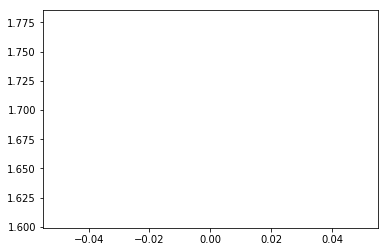

In [13]:
if __name__ == '__main__':
    ### Train test split:
    all_letters = string.ascii_letters + "0123456789 .,:!?’[]()/+-="
    # Plus EOS marker
    n_letters = len(all_letters) + 1
    all_categories = ['st']
    n_categories = 5
    
    category_lines, all_categories = getdata()
    train_dict, test_dict = train_test_split(category_lines)
    train_iter = iteratefromdict(train_dict)
    test_iter = iteratefromdict(test_dict)
    
    ### Shared Parameters
    num_epoch = 1
    model = RNN(n_letters, 100, 2, n_letters)
    
    train_loss_list, val_loss_list, val_acc_list, best_epoch, centences_list, best_model, samples = nn(model, num_epoch, train_iter, test_iter)
    plot_graph(train_loss_list, val_loss_list, val_acc_list, best_epoch, 'A')
    torch.save(best_model, 'best_model.dat')